# Credit Risk

In this notebook, I have used a paramteric (Logistic Regression) and a plug - in Non Parametric algorithm (XGBOOST). The feature engineering done mostly is to suit for the logistic regression model.
As non-parameteric models don't assume anything specific about the distribution, they tend to give better accuracy, although their visibility of the features is not as much as logistic regressi/on. 

In [196]:
#importing libraries
import warnings
warnings.simplefilter('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import scipy.stats.stats as stats
pd.set_option("max_columns", 10)
pd.set_option("max_rows",500)

In [197]:
df=pd.read_excel("case_study_data.xlsx")
df['status']=df['status'].apply(lambda x:1 if x==2 else 0)

In [198]:
display(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   checkin_acc        1000 non-null   object
 1   duration           1000 non-null   int64 
 2   credit_history     1000 non-null   object
 3   purpose            1000 non-null   object
 4   amount             1000 non-null   int64 
 5   svaing_acc         1000 non-null   object
 6   present_emp_since  1000 non-null   object
 7   inst_rate          1000 non-null   int64 
 8   personal_status    1000 non-null   object
 9   other_debtors      1000 non-null   object
 10  residing_since     1000 non-null   int64 
 11  property           1000 non-null   object
 12  age                1000 non-null   int64 
 13  inst_plans         1000 non-null   object
 14  housing            1000 non-null   object
 15  num_credits        1000 non-null   int64 
 16  job                1000 non-null   object
 

None

,checkin_acc,duration,credit_history,purpose,amount,...,job,dependents,telephone,foreign_worker,status
0,A11,9,A34,A43,1754,...,A173,2,A192,A201,0
1,A12,72,A32,A43,8927,...,A173,2,A191,A201,1
2,A14,18,A34,A46,3144,...,A172,3,A191,A201,0
3,A11,63,A32,A42,11823,...,A173,3,A191,A201,0
4,A11,36,A33,A40,7305,...,A173,3,A191,A201,1


In [199]:
#Column Desciptions
d={}
for col in df.columns:
    d.update({col:[df[col].nunique(), df[col].dtype, df[col].isnull().sum()]})

value_counts=pd.DataFrame.from_dict(d).transpose().reset_index()
value_counts.columns=['columns','unique values', 'type', 'num_of_missing']
value_counts=value_counts.sort_values(by='unique values',ascending=False).reset_index(drop=True)
value_counts

,columns,unique values,type,num_of_missing
0,amount,921,int64,0
1,age,53,int64,0
2,duration,33,int64,0
3,purpose,10,object,0
4,credit_history,5,object,0
5,svaing_acc,5,object,0
6,present_emp_since,5,object,0
7,checkin_acc,4,object,0
8,property,4,object,0
9,job,4,object,0


In [200]:
#Separating numeric columns for separate analyses
numeric_var_names=[key for key in dict(df.dtypes) if dict(df.dtypes)[key] =='int64']
numeric_var_names.remove("status")
numeric_var_names

['duration',
 'amount',
 'inst_rate',
 'residing_since',
 'age',
 'num_credits',
 'dependents']

In [201]:
#Performing univariate analysis of numeric columns

data_num=df[numeric_var_names]

def var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  x.std(), x.var(), x.std()/x.mean(), \
                      x.min(), x.dropna().quantile(0.01), x.dropna().quantile(0.05),x.dropna().quantile(0.10),\
                      x.dropna().quantile(0.25),x.dropna().quantile(0.50),x.dropna().quantile(0.75), x.dropna().quantile(0.90),\
                      x.dropna().quantile(0.95), x.dropna().quantile(0.99),x.max()], 
                  index=['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'CV','MIN', 'P1' , 'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

data_num.apply(var_summary).T

,N,NMISS,SUM,MEAN,MEDIAN,...,P75,P90,P95,P99,MAX
duration,1000.0,0.0,31449.0,31.449,27.0,...,36.0,54.0,72.00,90.00,108.0
amount,1000.0,0.0,4907134.0,4907.134,3479.5,...,5958.5,10769.1,13744.55,21271.08,27636.0
inst_rate,1000.0,0.0,4606.0,4.606,5.0,...,6.0,6.0,6.00,6.00,6.0
residing_since,1000.0,0.0,4407.0,4.407,5.0,...,6.0,6.0,6.00,6.00,6.0
age,1000.0,0.0,53566.0,53.566,50.0,...,63.0,78.0,90.00,101.01,113.0
num_credits,1000.0,0.0,2441.0,2.441,2.0,...,3.0,3.0,3.00,5.00,6.0
dependents,1000.0,0.0,2155.0,2.155,2.0,...,2.0,3.0,3.00,3.00,3.0


<Figure size 864x288 with 0 Axes>

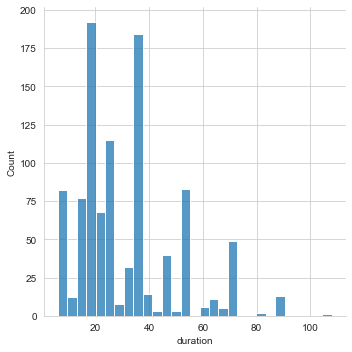

<Figure size 864x288 with 0 Axes>

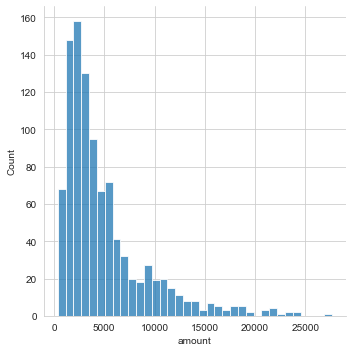

<Figure size 864x288 with 0 Axes>

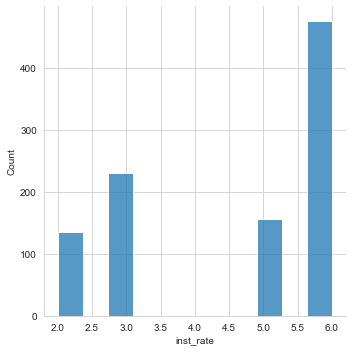

<Figure size 864x288 with 0 Axes>

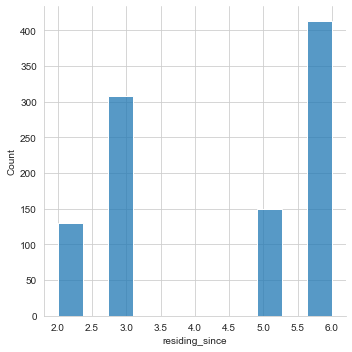

<Figure size 864x288 with 0 Axes>

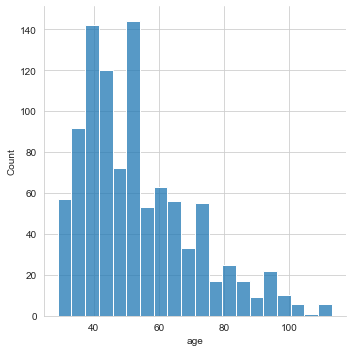

<Figure size 864x288 with 0 Axes>

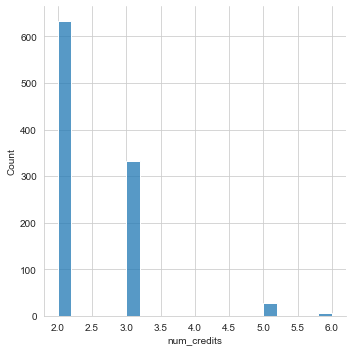

<Figure size 864x288 with 0 Axes>

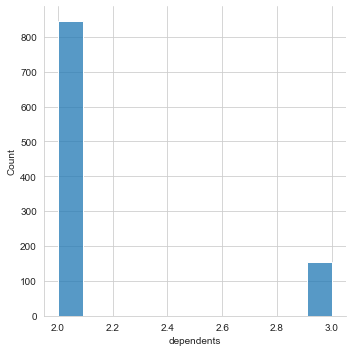

In [202]:
for col in numeric_var_names:
    plt.figure(col)
    sns.displot(df[col])

We obeserve that only duration, age and amount are continuous variables, and there is a presence of outlier in amount as gap between 99th quantile and max value is more.

We perform outlier treatment. Checking the number of customers (default & non default) falling between 99thquantile and max value, we cap the outlier with respective 99th quantile

In [203]:
display(df[df['amount']>21271.08]['status'].value_counts())
q99_status0=df[df['status']==0]['amount'].quantile(0.99)
q99_status1=df[df['status']==1]['amount'].quantile(0.99)
if (df['status']==0).any():
    df['amount']=np.where(df['amount'] > q99_status0, q99_status0,df['amount'])
else:
    df['amount']=np.where(df['amount'] > q99_status1, q99_status1, df['amount'])

1    8
0    2
Name: status, dtype: int64

In [204]:
#Function to plot kde and box plot
def plot_distribution_comp(var):
    i = -1
    t1 = df.loc[df['status'] == 1]
    t0 = df.loc[df['status'] == 0]
    nrow=len(var)

    sns.set_style('whitegrid')
    fig, ax = plt.subplots(len(var),2,figsize=(12,6*nrow))

    for feature in var:
        i += 1
        sns.kdeplot(t0[feature], bw=0.5,label="TARGET =No default", ax=ax[i,0])
        sns.kdeplot(t1[feature], bw=0.5,label="TARGET =default",ax=ax[i, 0])
        sns.boxplot(y=df[feature], x=df['status'],ax=ax[i,1])
        ax[i,0].set_ylabel('Density plot', fontsize=12)
        ax[i, 0].set_xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show();

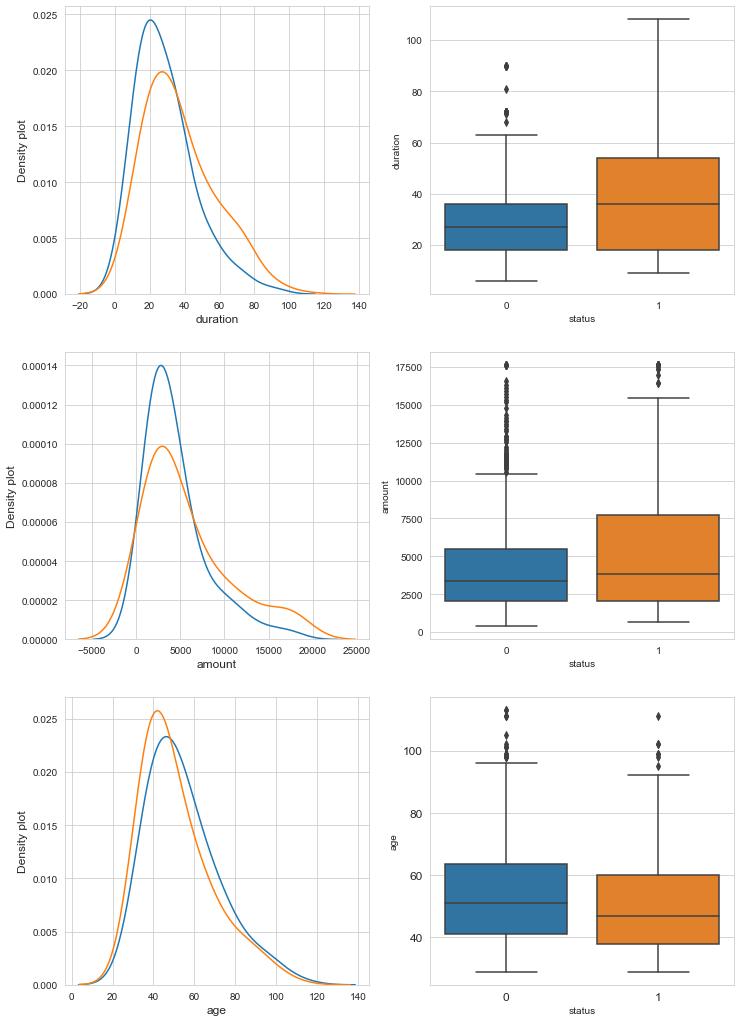

In [205]:
plot_distribution_comp(['duration', 'amount', 'age'])

We observe that outlier has been treated and we want to check whether these variables have impact on our target variable. We will perform t-test for indepedent sample mean, under the null hypothesis that these two distributions have independet sample means. We look for p value in order to check for evidence against our null hypothesis

T test for independent sample means

In [206]:
def t_test_ind_samples(df,var):
    t1 = df.loc[df['status'] == 1]
    t0 = df.loc[df['status'] == 0]
    mean1, std1,nobs1=t1[var].mean(), t1[var].std(), t1[var].shape[0]
    mean0, std0,nobs0=t0[var].mean(), t0[var].std(), t0[var].shape[0]
    return stats.ttest_ind_from_stats(mean0, std0,nobs0, mean1, std1,nobs1)

for col in ['duration', 'amount', 'age']:
    print("\n\n t test of independence for variable {} is {}".\
          format(col,t_test_ind_samples(df, col)))



 t test of independence for variable duration is Ttest_indResult(statistic=-6.9434957066198635, pvalue=6.883579432109325e-12)


 t test of independence for variable amount is Ttest_indResult(statistic=-4.741279250983013, pvalue=2.432320559180808e-06)


 t test of independence for variable age is Ttest_indResult(statistic=2.8806049181797295, pvalue=0.004054058455594808)


P value is less than our assumed level of significance (alpha=0.05) and hence we reject the null hypothesis. Now, we will bin perform binning of this continuous variable as it would make more sense to subsitute the category with weight of evidence rather than including untreated variable.

In [207]:
#finding optimal bin size by using chi2 statistic of binned variable wrt status 
def binned(df,var, max_bin=10):
    pvalues=[]
    for b in range(2, max_bin+1):
        try:
            df[var+"bin"+str(b)]=pd.qcut(df[var], q=b ).apply(lambda x: str(x))
            stat, p, dof, expected=chi2_contingency(pd.crosstab(df['status'], df[var+"bin"+str(b)]))
            pvalues.append([b, p])
        except Exception as e:
            pass
    pvalues=pd.DataFrame(pvalues, columns=['bins', 'pvalue assuming independence'])
    bin_size=pvalues[pvalues['pvalue assuming independence']==pvalues\
            ['pvalue assuming independence'].min()]['bins'].values[0]
    return bin_size

In [208]:
#optimal bin size for each variable and performing monotonic binning
df1=df.copy()
for col in ['duration', 'amount', 'age']:
    opt_bin=binned(df1, col, 25)
    print("optimal binning size for variable {} is {}".format(col, opt_bin))
    df[col]=pd.qcut(df[col], q= opt_bin).apply(lambda x: str(x))

optimal binning size for variable duration is 5
optimal binning size for variable amount is 19
optimal binning size for variable age is 2


Performing EDA of categorical Variables

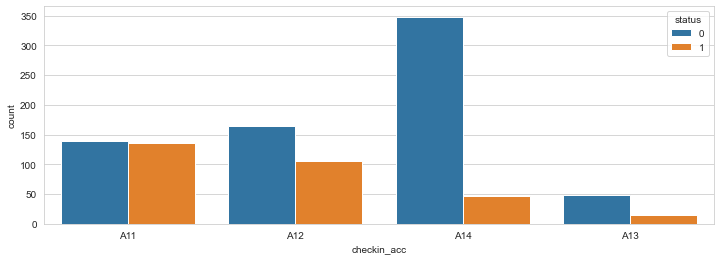

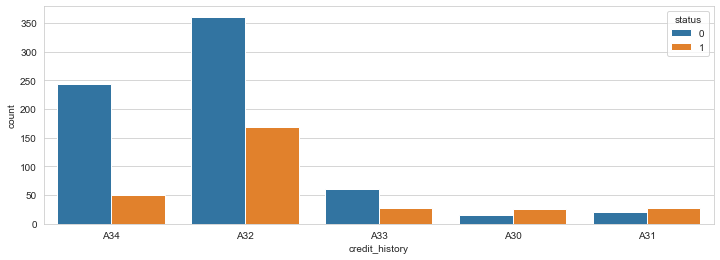

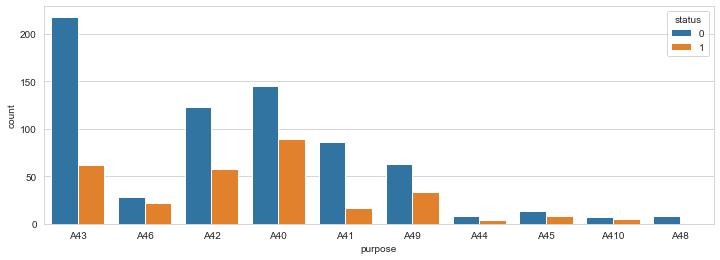

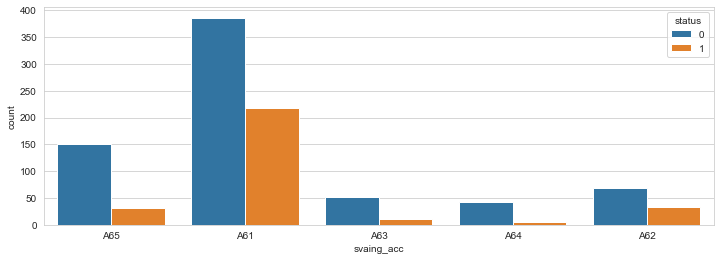

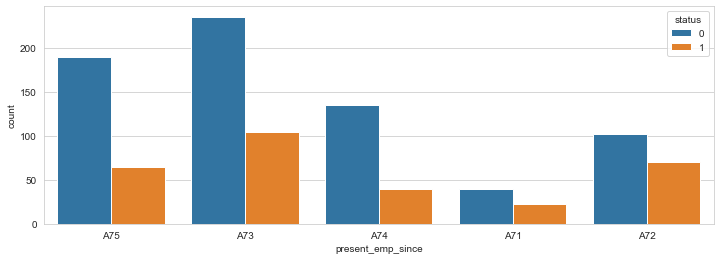

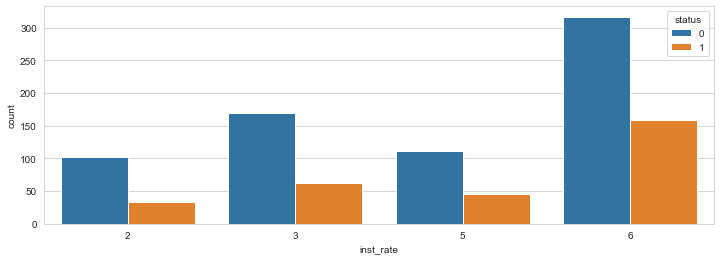

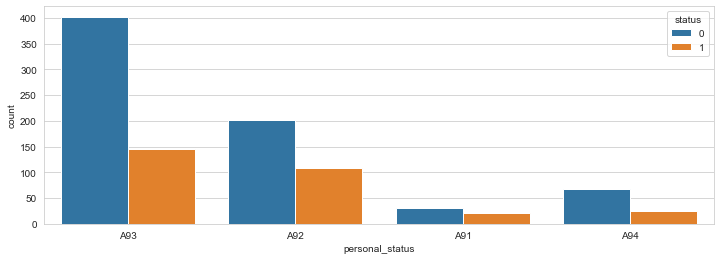

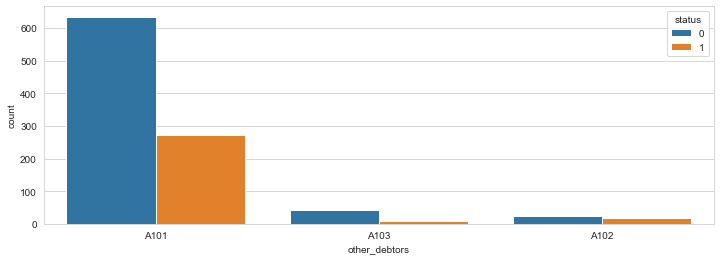

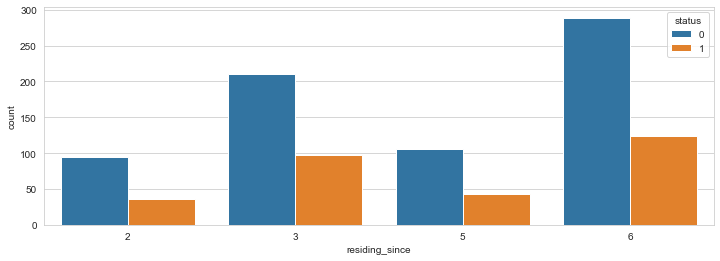

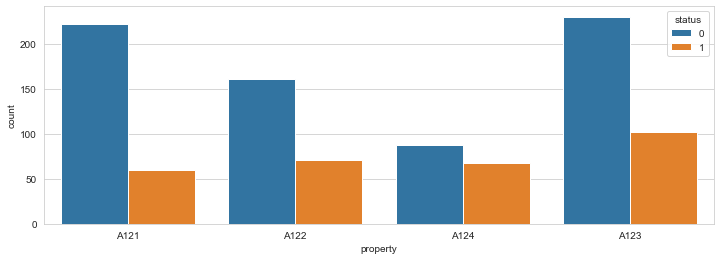

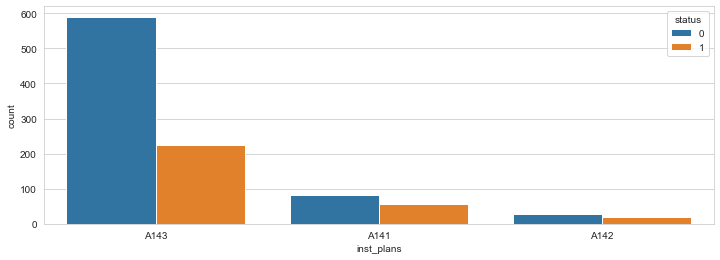

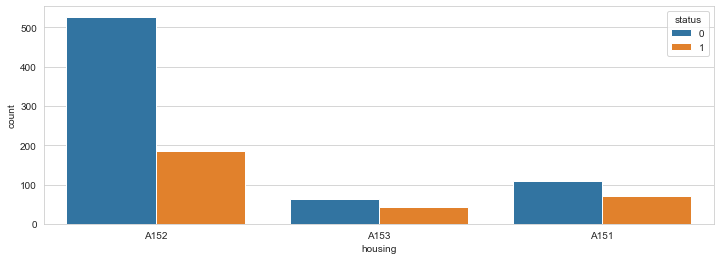

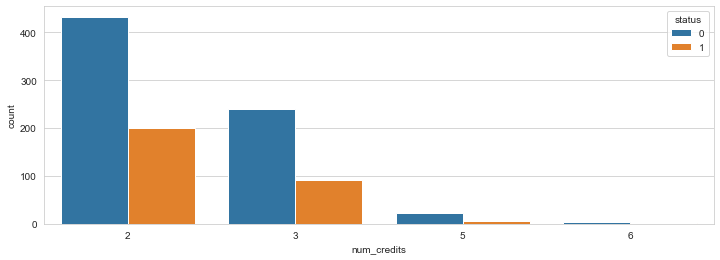

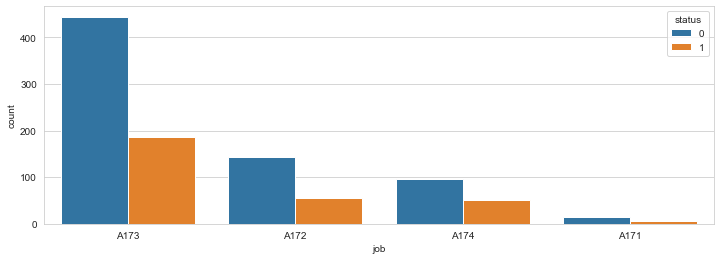

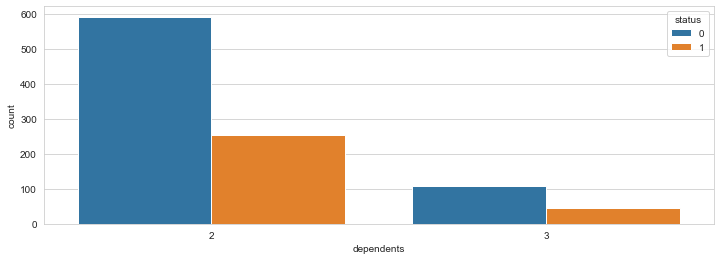

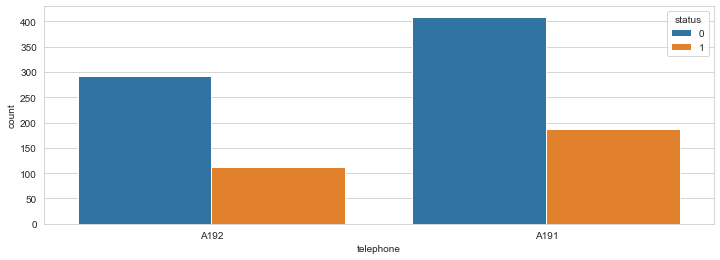

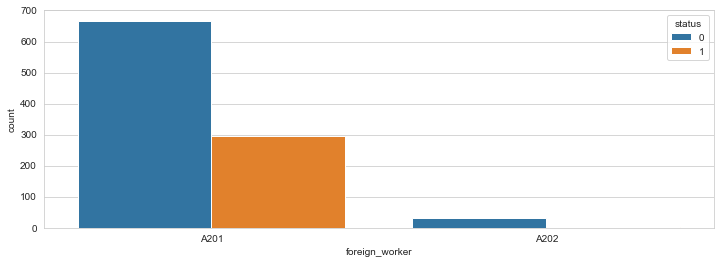

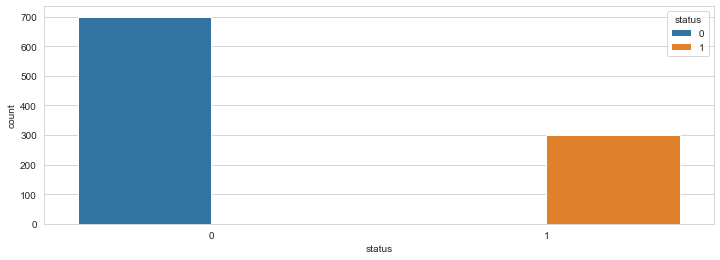

In [209]:
for col in [x for x in df.columns if x not in ['duration', 'amount', 'age']]:
    plt.figure(col)
    sns.countplot(x=df[col], hue=df['status'])

In [210]:
#performing chi2 test for independence for each categorical variable
d={}
for col in [x for x in df.columns if x not in ['duration', 'amount', 'age']]:
    stat, p, dof, expected=chi2_contingency(pd.crosstab(df['status'], df[col]))
    d.update({col: [p]})

pvalues=pd.DataFrame.from_dict(d).T.reset_index()
pvalues.columns=['columns', 'pvalue assuming indepedence']
pvalues['p<0.05']=pvalues['pvalue assuming indepedence'].apply(lambda x: True if x<0.05 else False)
pvalues.sort_values(by='pvalue assuming indepedence', ascending=False).reset_index(drop=True)

,columns,pvalue assuming indepedence,p<0.05
0,dependents,1.000000e+00,False
1,residing_since,8.615521e-01,False
2,job,5.965816e-01,False
3,num_credits,4.451441e-01,False
4,telephone,2.788762e-01,False
5,inst_rate,1.400333e-01,False
6,other_debtors,3.605595e-02,True
7,personal_status,2.223801e-02,True
8,foreign_worker,1.583075e-02,True
9,inst_plans,1.629318e-03,True


We see that, we fail to reject null hypothesis of chi2 test for some of the variables. We are still keeping it and will eliminate based on information value

In [211]:
#Dummy encoding of all variables (categorical and binned continuous)
df_orig=df.copy()
for col in [x for x in df.columns if x not in ['status']]:
    var=cont = pd.get_dummies(df[col],prefix=col+'_',drop_first=True)
    df = pd.concat([df,var],axis=1)
    df.drop([col], axis=1, inplace=True)

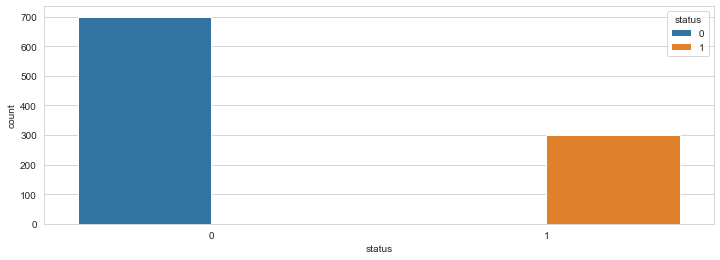

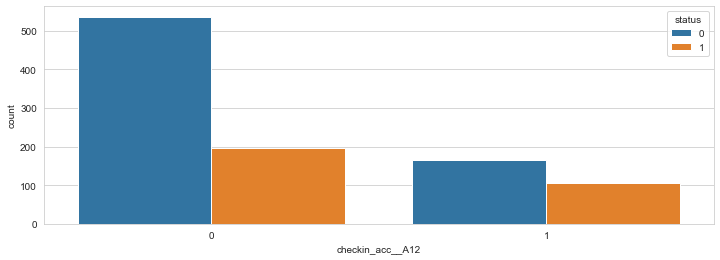

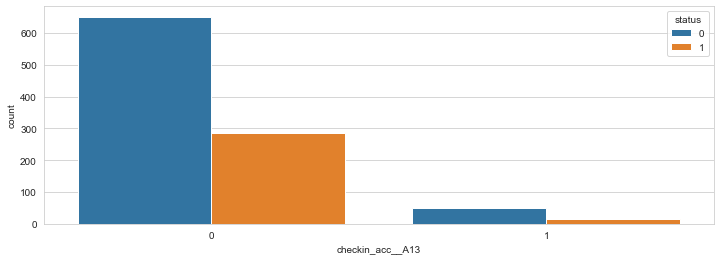

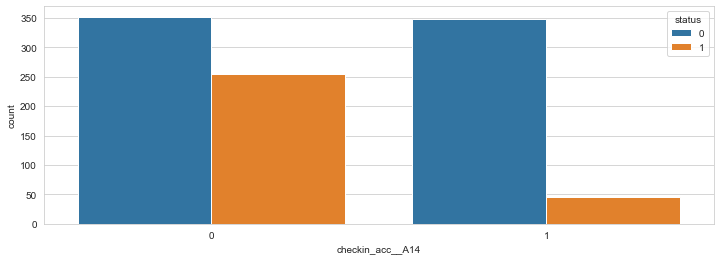

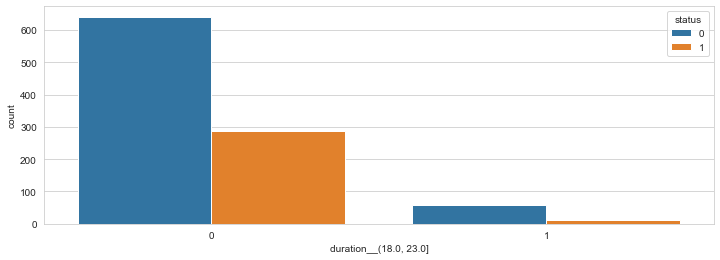

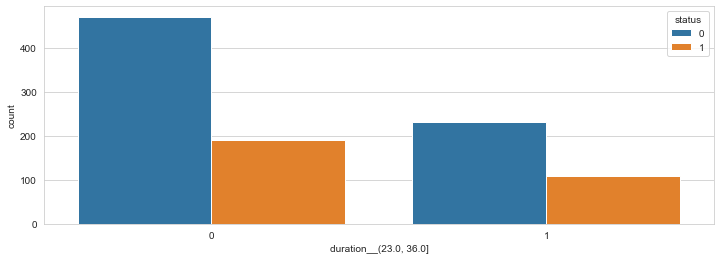

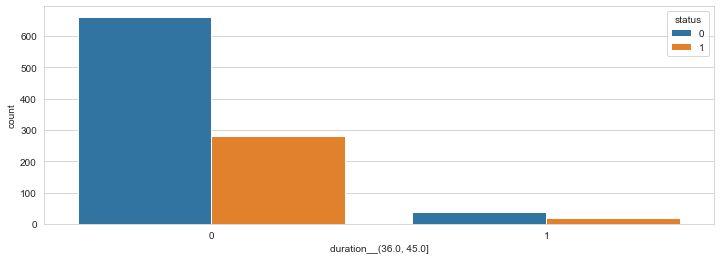

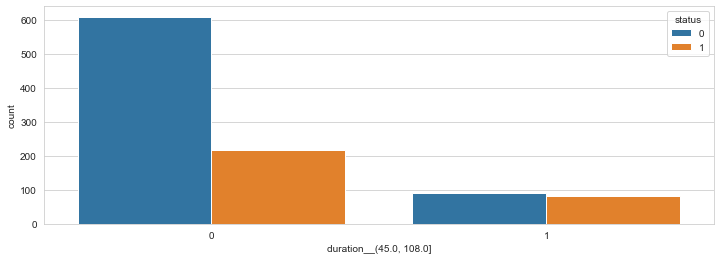

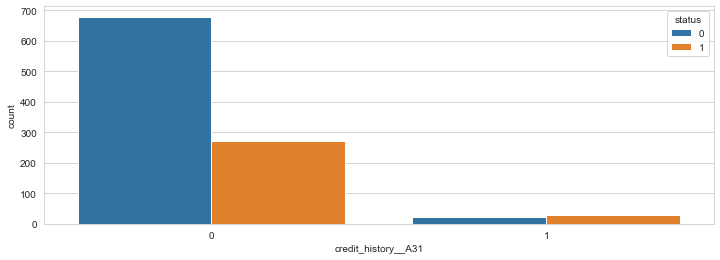

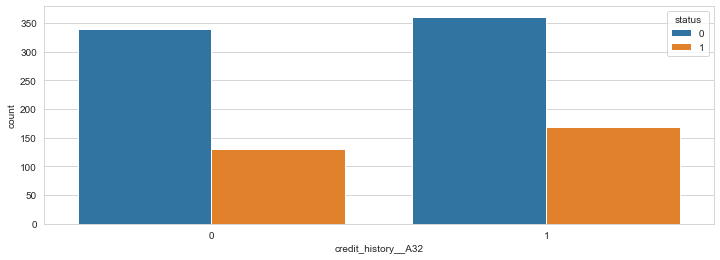

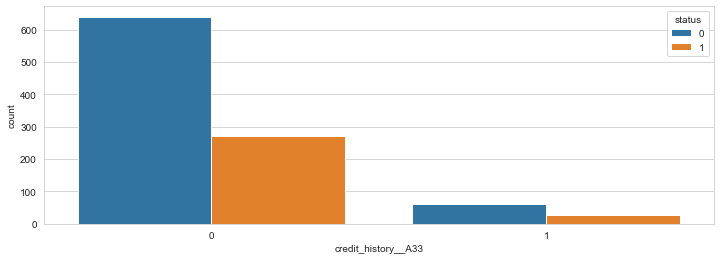

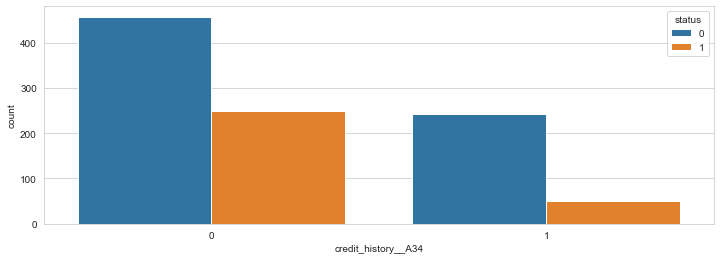

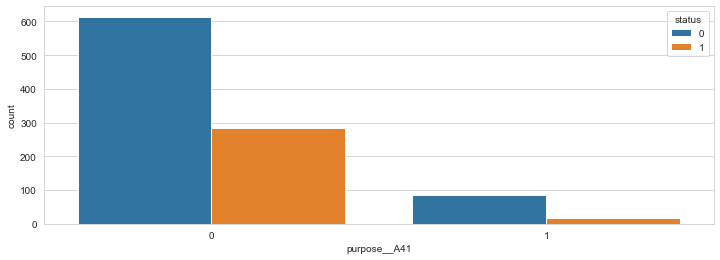

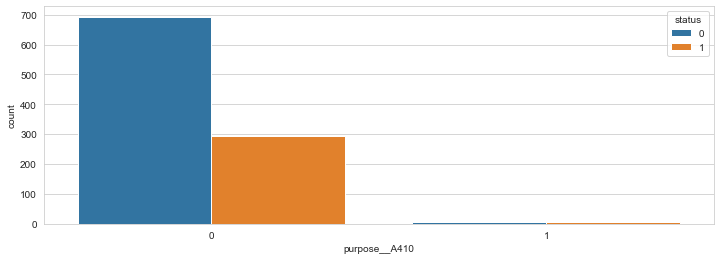

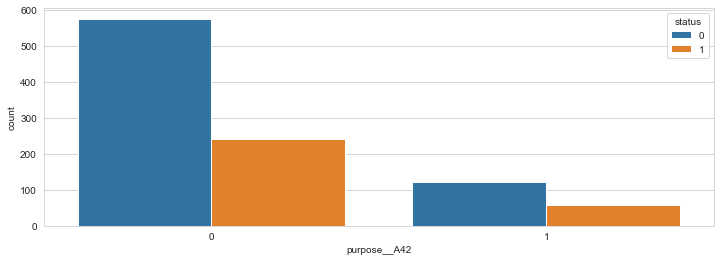

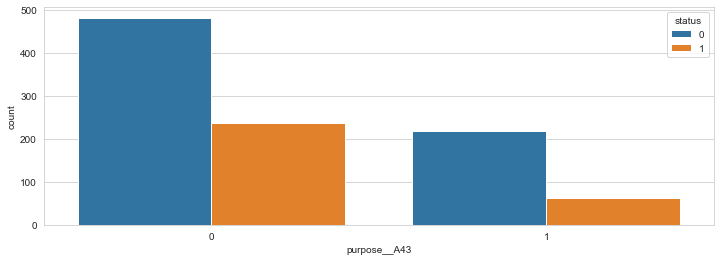

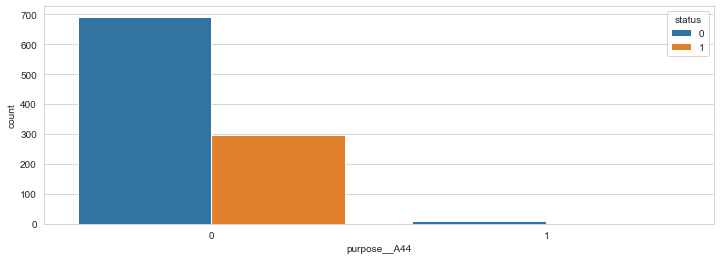

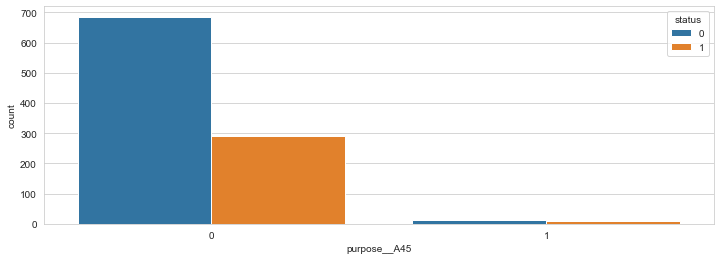

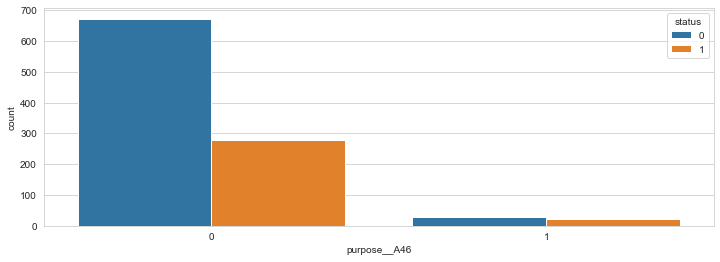

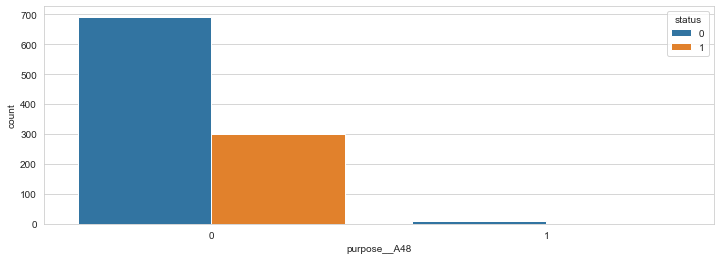

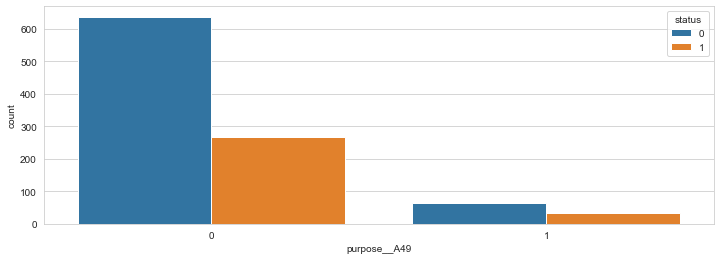

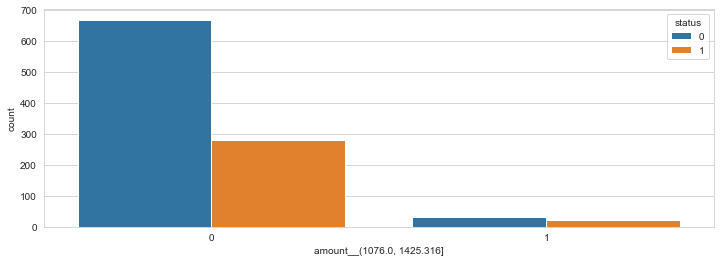

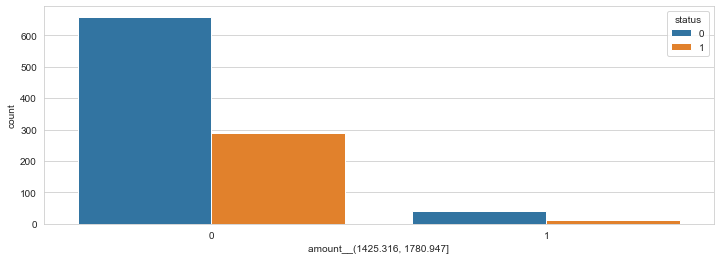

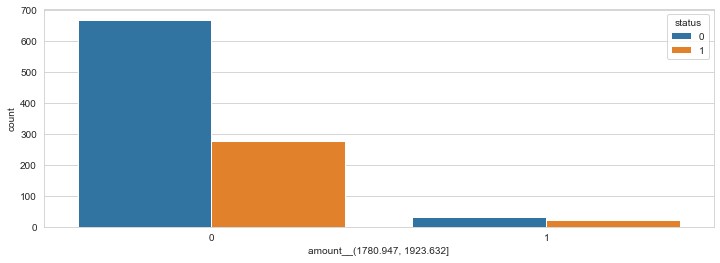

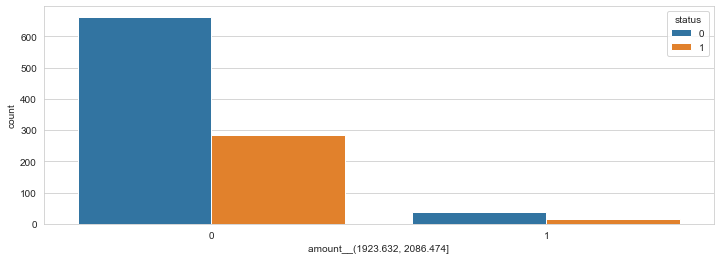

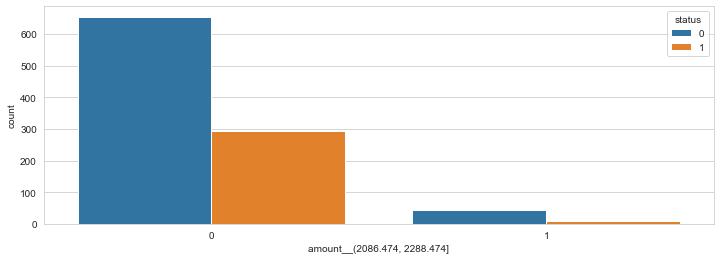

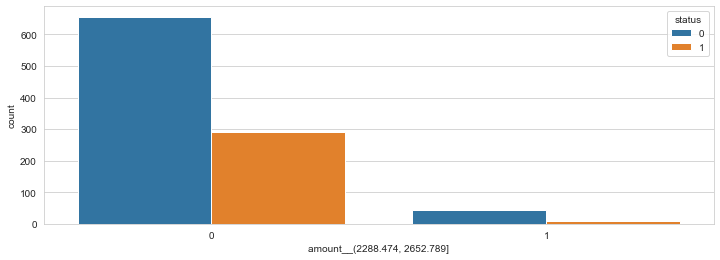

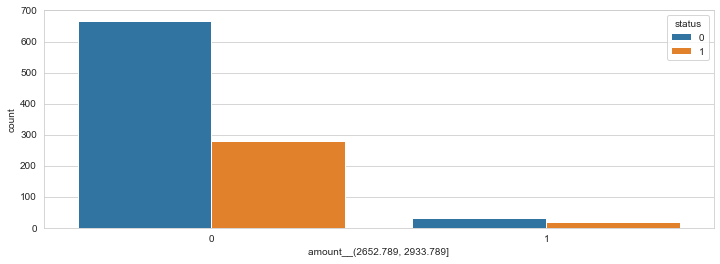

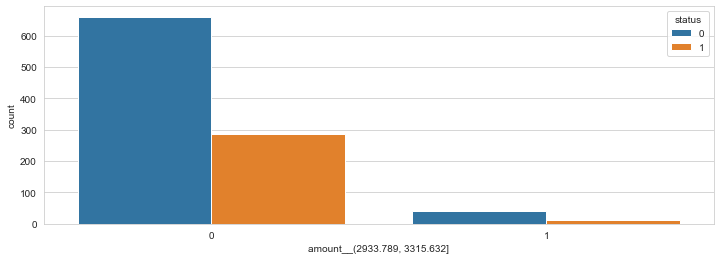

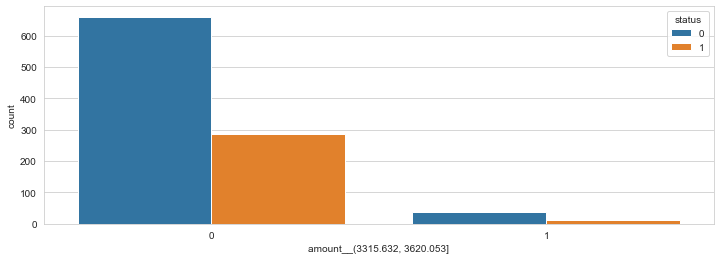

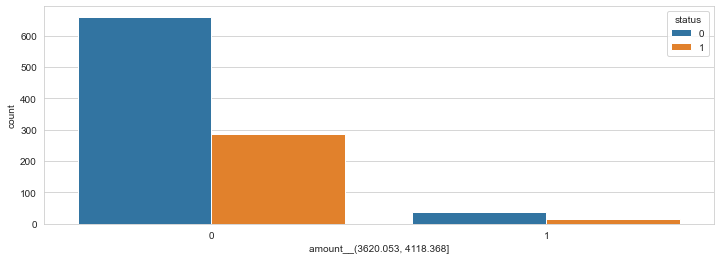

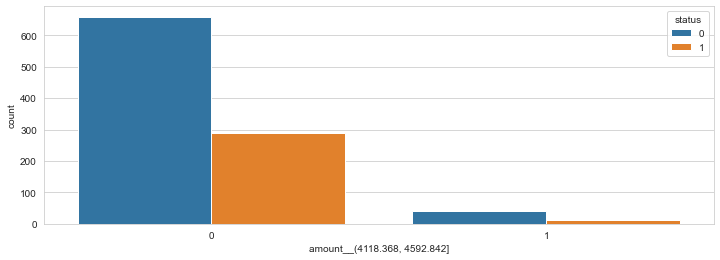

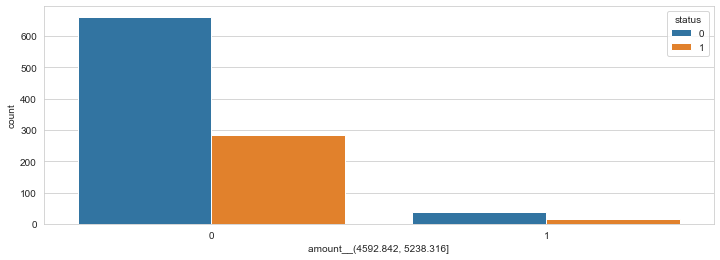

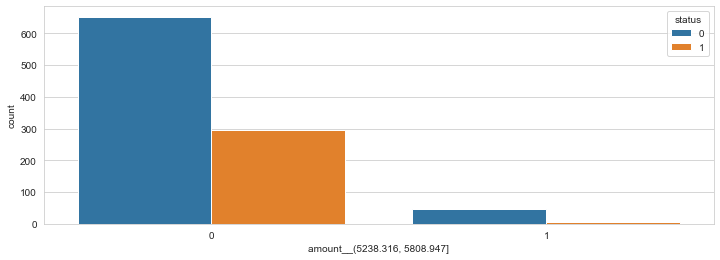

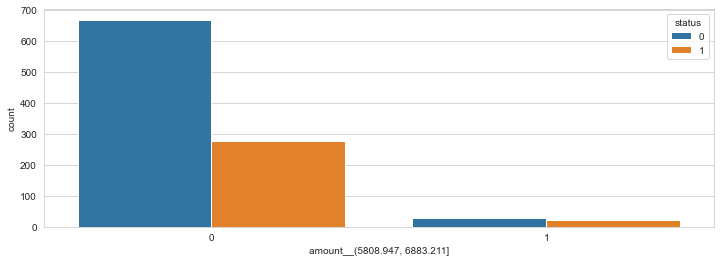

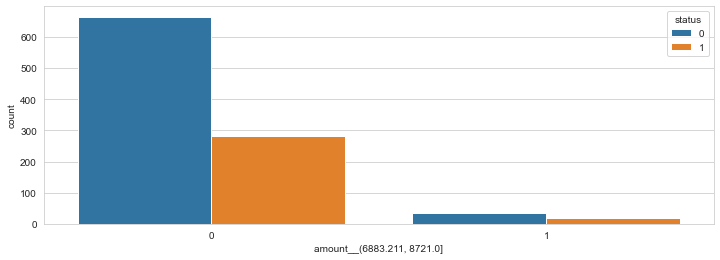

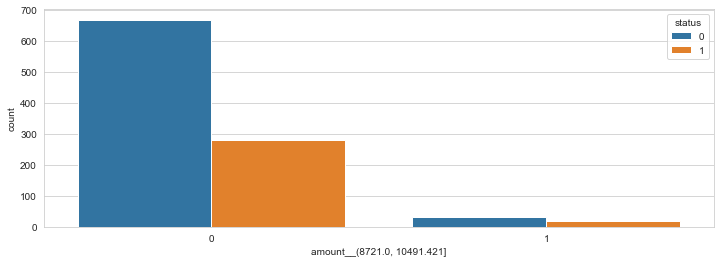

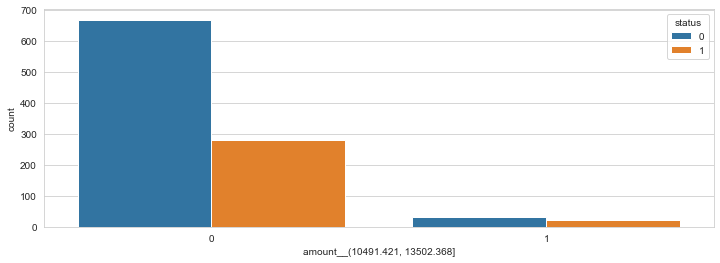

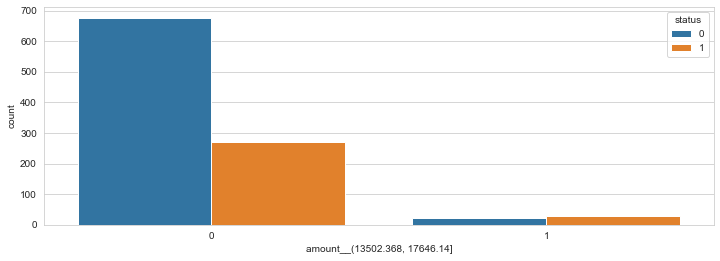

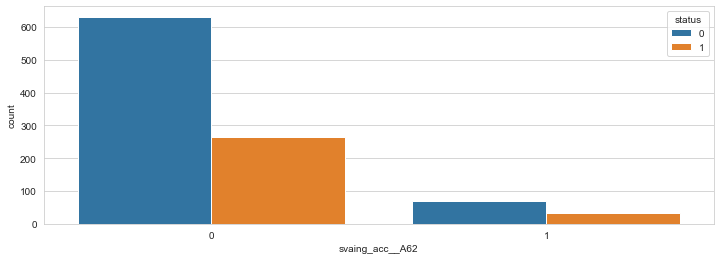

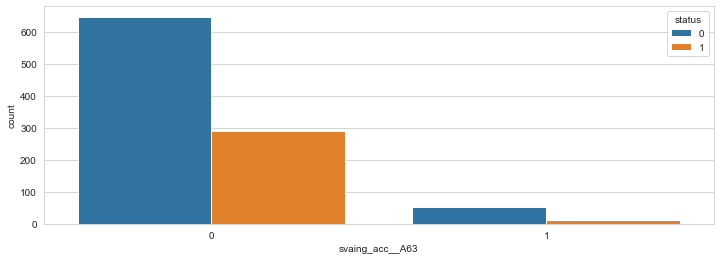

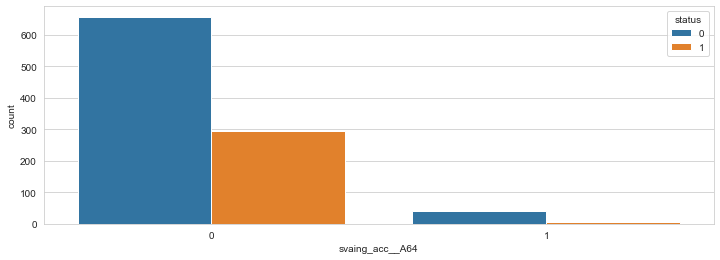

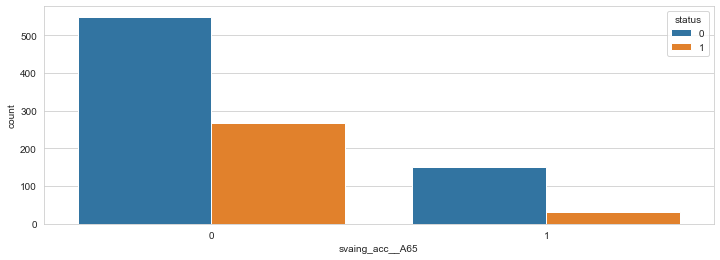

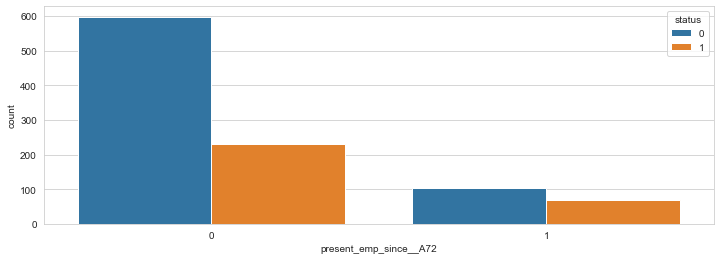

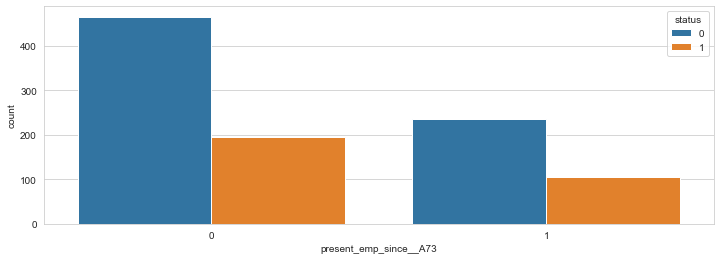

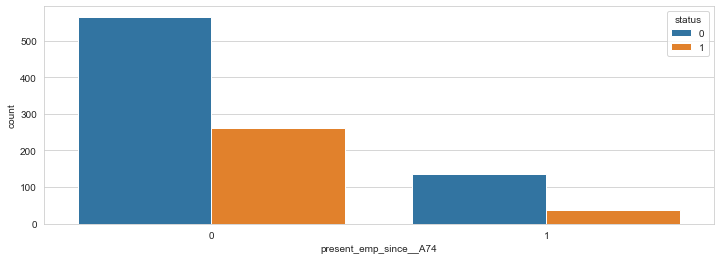

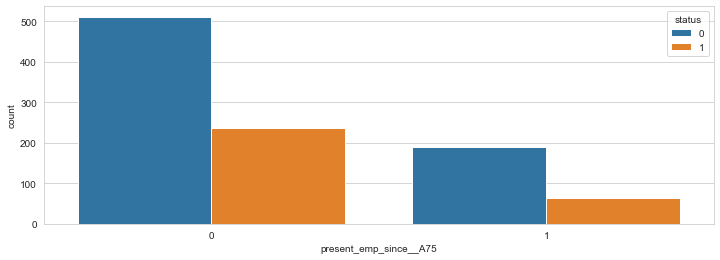

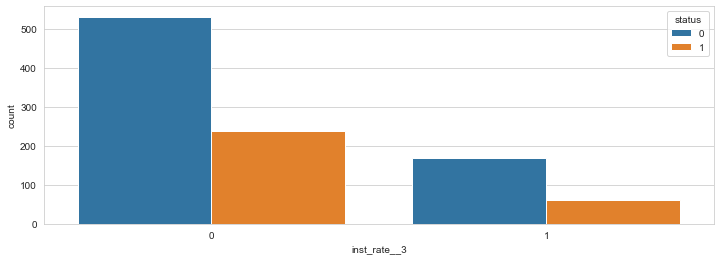

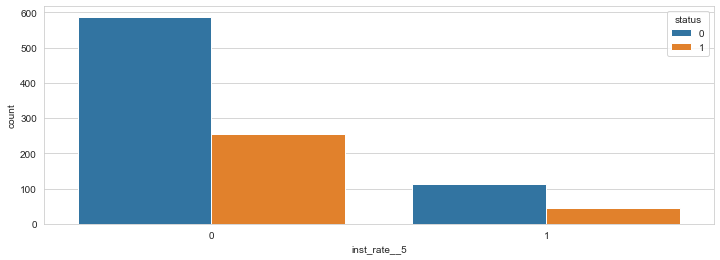

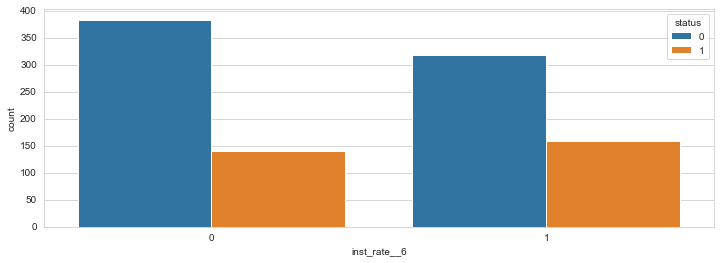

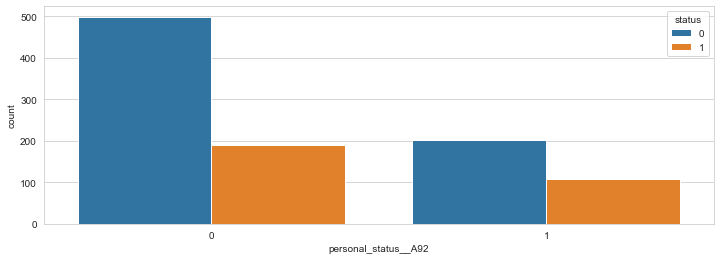

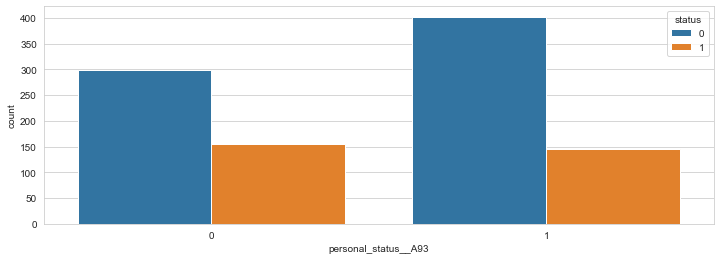

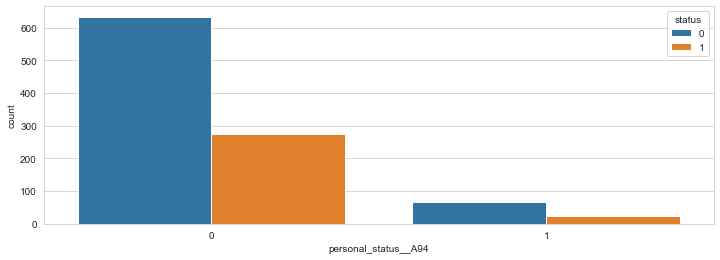

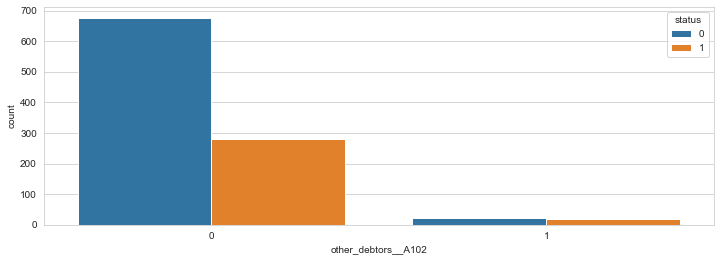

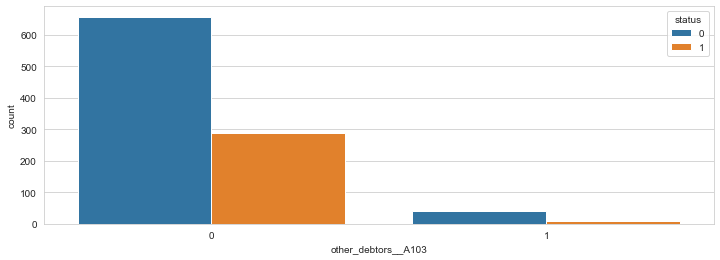

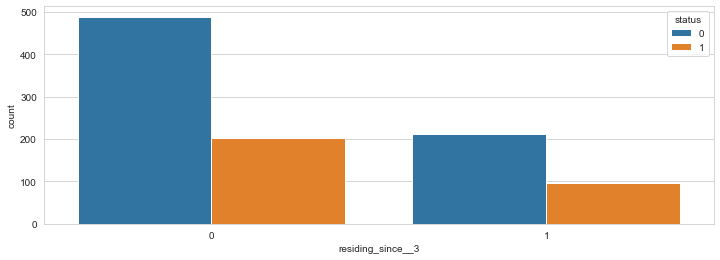

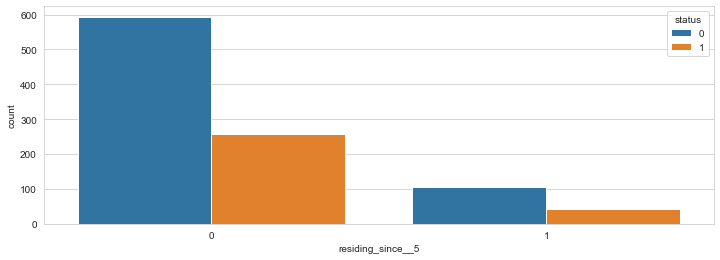

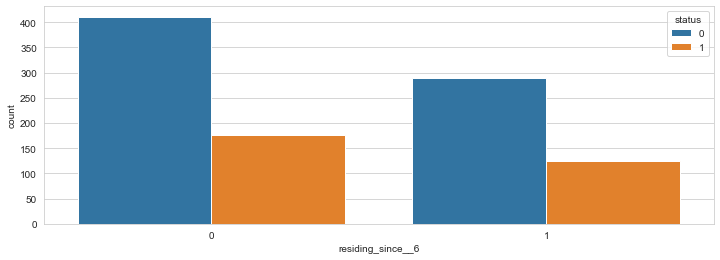

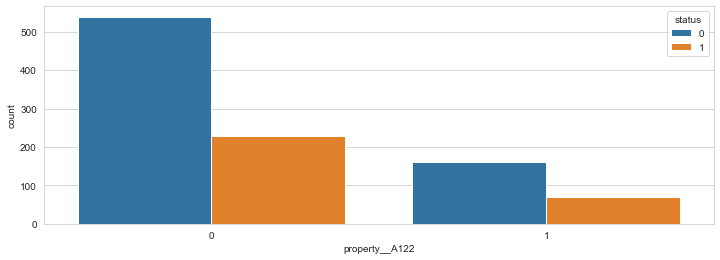

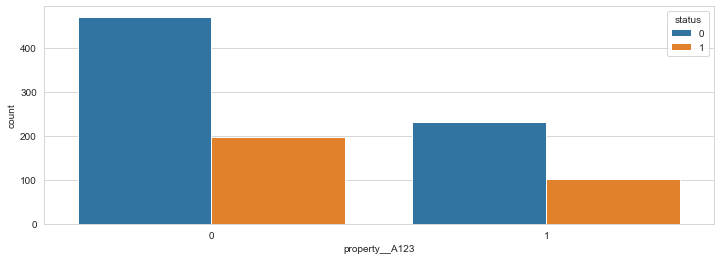

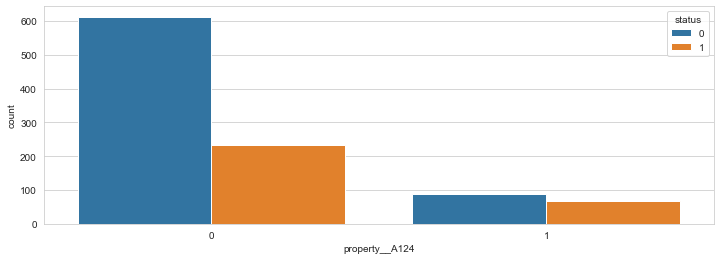

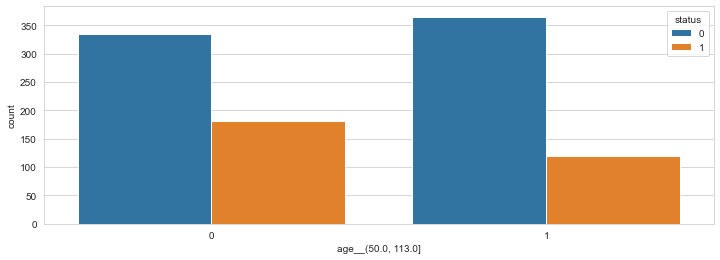

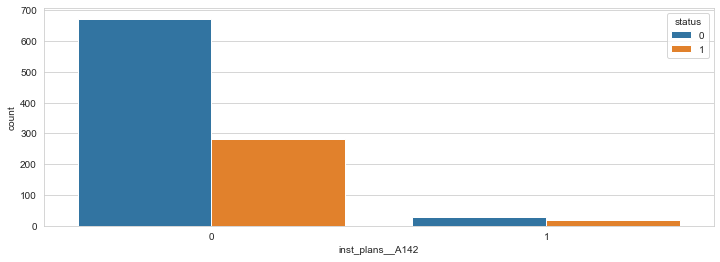

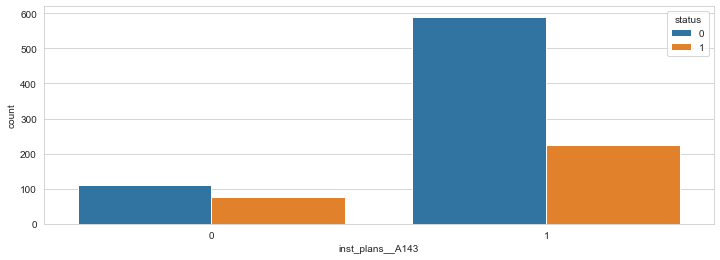

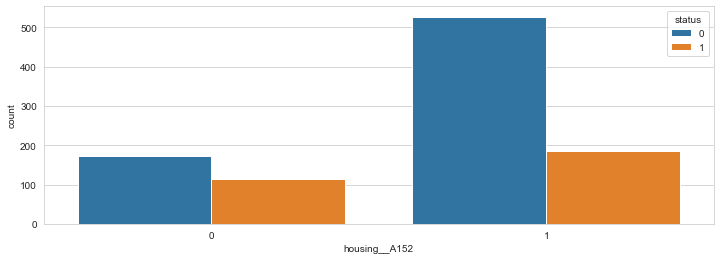

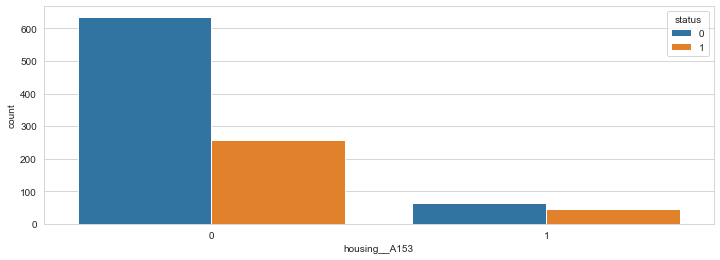

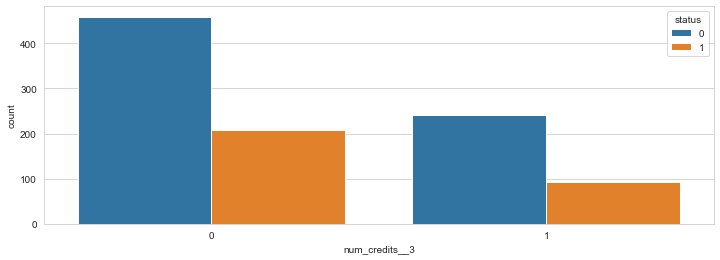

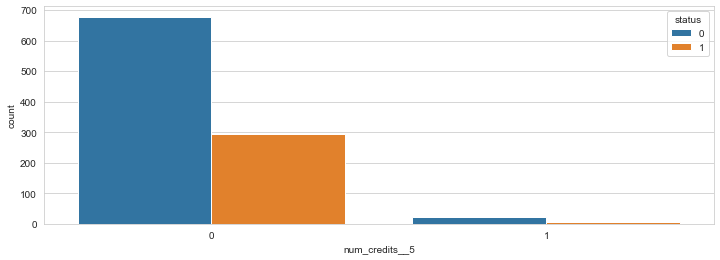

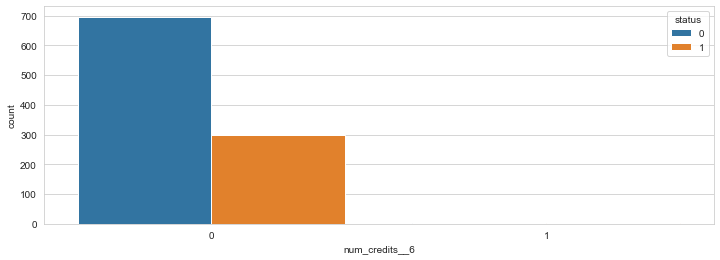

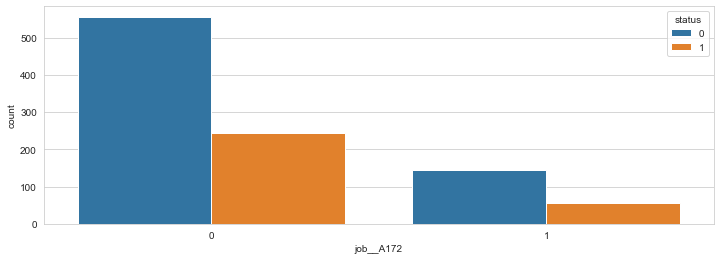

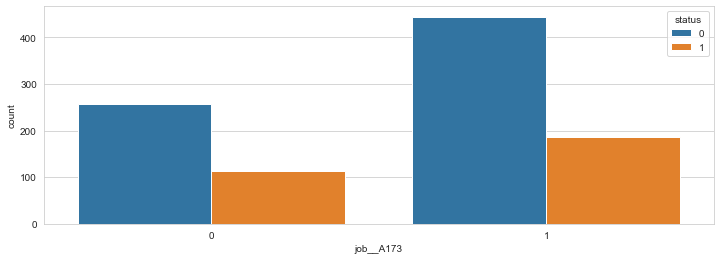

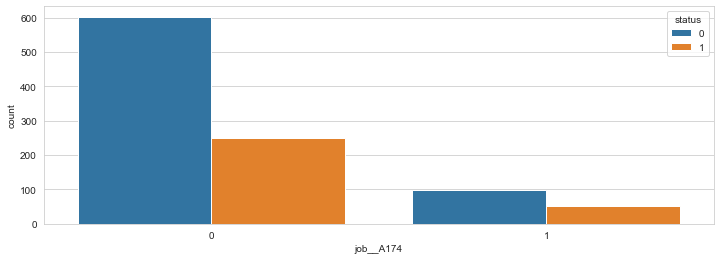

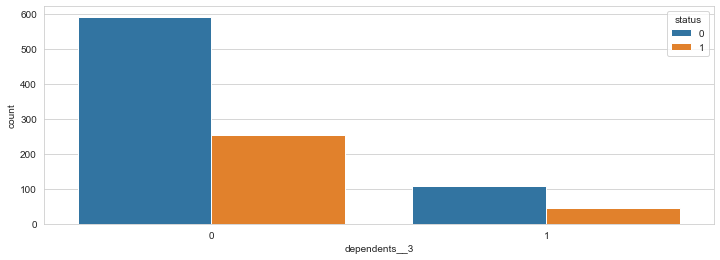

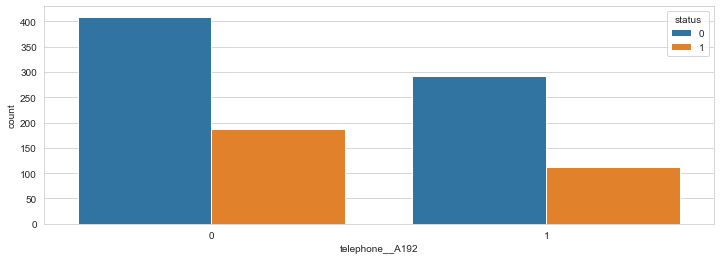

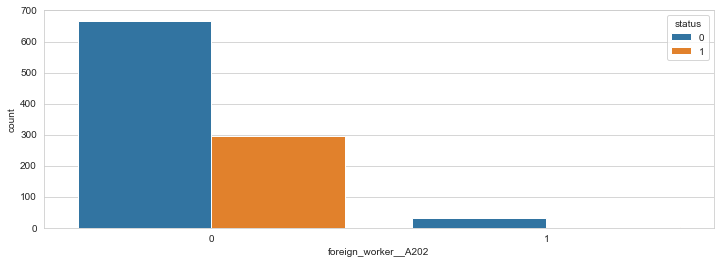

In [212]:
for col in df.columns:
    plt.figure(col)
    sns.countplot(x=df[col], hue=df['status'])

In [213]:
#similarly for performing chi2 test for all variables  
d={}
for col in [x for x in df.columns if x!='status']:
    stat, p, dof, expected=chi2_contingency(pd.crosstab(df['status'], df[col]))
    d.update({col: [p]})

pvalues=pd.DataFrame.from_dict(d).T.reset_index()
pvalues.columns=['columns', 'pvalue assuming indepedence']
pvalues=pvalues.sort_values(by='pvalue assuming indepedence', ascending=False).reset_index(drop=True)
pvalues['p<0.05']=pvalues['pvalue assuming indepedence'].apply(lambda x: True if x<0.05 else False)

pvalues

,columns,pvalue assuming indepedence,p<0.05
0,dependents__3,1.000000e+00,False
1,"amount__(1923.632, 2086.474]",9.752055e-01,False
2,residing_since__6,9.552937e-01,False
3,purpose__A44,9.494675e-01,False
4,"amount__(4592.842, 5238.316]",9.019427e-01,False
5,property__A122,8.830275e-01,False
6,residing_since__5,8.161120e-01,False
7,present_emp_since__A73,7.930138e-01,False
8,credit_history__A33,7.887423e-01,False
9,num_credits__6,7.886480e-01,False


In [214]:
# Function to find out WOE and Information Value
import pandas as pd
import numpy as np
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string


def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [215]:
final_iv, IV = data_vars(df,df.status)

In [216]:
final_iv

,VAR_NAME,MIN_VALUE,MAX_VALUE,COUNT,EVENT,...,NON_EVENT_RATE,DIST_EVENT,DIST_NON_EVENT,WOE,IV
0,checkin_acc__A12,0,0,731,195,...,0.733242,0.650000,0.765714,-0.163837,6.540502e-02
1,checkin_acc__A12,1,1,269,105,...,0.609665,0.350000,0.234286,0.401392,6.540502e-02
2,checkin_acc__A13,0,0,937,286,...,0.694771,0.953333,0.930000,0.024780,1.003905e-02
3,checkin_acc__A13,1,1,63,14,...,0.777778,0.046667,0.070000,-0.405465,1.003905e-02
4,checkin_acc__A14,0,0,606,254,...,0.580858,0.846667,0.502857,0.521001,5.835356e-01
5,checkin_acc__A14,1,1,394,46,...,0.883249,0.153333,0.497143,-1.176263,5.835356e-01
6,"duration__(18.0, 23.0]",0,0,928,287,...,0.690733,0.956667,0.915714,0.043751,2.903691e-02
7,"duration__(18.0, 23.0]",1,1,72,13,...,0.819444,0.043333,0.084286,-0.665290,2.903691e-02
8,"duration__(23.0, 36.0]",0,0,661,191,...,0.711044,0.636667,0.671429,-0.053161,5.343873e-03
9,"duration__(23.0, 36.0]",1,1,339,109,...,0.678466,0.363333,0.328571,0.100566,5.343873e-03


We see that IV is less than 0.02, for the cases where we were failing to reject null hypothesis of chi2 test, which means they are weak predictor. We will drop them 

In [217]:
pd.merge(pvalues, IV.rename(columns={'VAR_NAME':'columns'}), on='columns', how='left')

,columns,pvalue assuming indepedence,p<0.05,IV
0,dependents__3,1.000000e+00,False,4.339223e-05
1,"amount__(1923.632, 2086.474]",9.752055e-01,False,1.673769e-04
2,residing_since__6,9.552937e-01,False,9.352843e-07
3,purpose__A44,9.494675e-01,False,2.972939e-04
4,"amount__(4592.842, 5238.316]",9.019427e-01,False,3.718268e-04
5,property__A122,8.830275e-01,False,2.484605e-04
6,residing_since__5,8.161120e-01,False,5.216227e-04
7,present_emp_since__A73,7.930138e-01,False,5.336891e-04
8,credit_history__A33,7.887423e-01,False,7.125795e-04
9,num_credits__6,7.886480e-01,False,1.477229e-04


In [218]:
selected_columns=list(pvalues[pvalues['p<0.05']]['columns'].values)
selected_columns

['amount__(2288.474, 2652.789]',
 'purpose__A46',
 'svaing_acc__A63',
 'duration__(18.0, 23.0]',
 'inst_rate__6',
 'amount__(2086.474, 2288.474]',
 'present_emp_since__A74',
 'personal_status__A92',
 'foreign_worker__A202',
 'housing__A153',
 'personal_status__A93',
 'svaing_acc__A64',
 'purpose__A41',
 'amount__(5238.316, 5808.947]',
 'present_emp_since__A72',
 'purpose__A43',
 'inst_plans__A143',
 'age__(50.0, 113.0]',
 'checkin_acc__A12',
 'property__A124',
 'svaing_acc__A65',
 'credit_history__A31',
 'housing__A152',
 'amount__(13502.368, 17646.14]',
 'duration__(45.0, 108.0]',
 'credit_history__A34',
 'checkin_acc__A14']

In [219]:
transform_prefix = 'WOE_'

In [299]:
#Performing WOE transformation
for var in selected_columns:
    small_df = final_iv[final_iv['VAR_NAME'] == var]
    transform_dict = dict(zip(small_df.MAX_VALUE,small_df.WOE))
    replace_cmd = ''
    replace_cmd1 = ''
    for i in sorted(transform_dict.items()):
        replace_cmd = replace_cmd + str(i[1]) + str(' if x <= ') + str(i[0]) + ' else '
        replace_cmd1 = replace_cmd1 + str(i[1]) + str(' if x == "') + str(i[0]) + '" else '
    replace_cmd = replace_cmd + '0'
    replace_cmd1 = replace_cmd1 + '0'
    if replace_cmd != '0':
        try:
            df[transform_prefix + var] = df[var].apply(lambda x: eval(replace_cmd))
        except:
            df[transform_prefix + var] = df[var].apply(lambda x: eval(replace_cmd1))

In [300]:
X=df[[transform_prefix+x for x in selected_columns]]
y=df['status']

In [301]:
#saving final model data
model_data=pd.concat([X, y], axis=1)
model_data.to_csv("Final_Model_Data.csv")

In [302]:
from sklearn.model_selection import train_test_split


In [303]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7,test_size=0.3,random_state=42)

In [304]:
print(y_train.mean())
print(y_test.mean())

0.2985714285714286
0.30333333333333334


In [305]:
import statsmodels.api as sm

In [306]:
# Logistic regression model
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
res=logm1.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 status   No. Observations:                  700
Model:                            GLM   Df Residuals:                      672
Model Family:                Binomial   Df Model:                           27
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -330.24
Date:                Fri, 18 Sep 2020   Deviance:                       660.48
Time:                        06:39:22   Pearson chi2:                     693.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                -0.8251      0.099     -8.311      0.000      -1.020      -0.631
WOE_amount__(2288.474, 2652.789]      0.7171      0.660      1.087      0.277      -0.576       2.011
WOE_purpose__A46                      0.4966      0.754      0.658      0.510      -0.982       1.975
WOE_svaing_acc__A63                   0.9667      0.627      1.541      0.123      -0.263       2.196
WOE_duration__(18.0, 23.0]            0.7573      0.576      1.315      0.189      -0.372       1.886
WOE_inst_rate__6                      1.6137      0.651      2.479      0.013       0.338       2.890
WOE_amount__(2086.474, 2288.474]      0.8629      0.566      1.523      0.128      -0.247       1.973
WOE_present_emp_since__A74            0.3981      0.577      0.690      0.490      -0.733       1.529
WOE_personal_status__A92              0.0786      0.883      0.089      0.929      -1.652       1.809
WOE_foreign_worker__A202              0.9129      0.529      1.725      0.085      -0.124       1.950
WOE_housing__A153                    -0.6072      1.041     -0.583      0.560      -2.648       1.434
WOE_personal_status__A93              0.9335      0.854      1.093      0.275      -0.741       2.608
WOE_svaing_acc__A64                   0.9239      0.518      1.783      0.075      -0.091       1.939
WOE_purpose__A41                      1.2353      0.458      2.694      0.007       0.337       2.134
WOE_amount__(5238.316, 5808.947]      0.9441      0.364      2.595      0.009       0.231       1.657
WOE_present_emp_since__A72            0.3125      0.454      0.689      0.491      -0.577       1.202
WOE_purpose__A43                      1.2830      0.427      3.005      0.003       0.446       2.120
WOE_inst_plans__A143                  0.5563      0.415      1.339      0.180      -0.258       1.371
WOE_age__(50.0, 113.0]                1.0403      0.426      2.442      0.015       0.205       1.875
WOE_checkin_acc__A12                 -0.4200      0.403     -1.041      0.298      -1.211       0.371
WOE_property__A124                    0.8895      0.648      1.373      0.170      -0.380       2.159
WOE_svaing_acc__A65                   0.6237      0.331      1.885      0.059      -0.025       1.272
WOE_credit_history__A31               0.6299      0.383      1.645      0.100      -0.120       1.380
WOE_housing__A152                     0.6786      0.421      1.612      0.107      -0.147       1.504
WOE_amount__(13502.368, 17646.14]     0.5077      0.343      1.482      0.138      -0.164       1.179
WOE_duration__(45.0, 108.0]           0.9014      0.283      3.182      0.001       0.346       1.457
WOE_credit_history__A34               0.7618      0.250      3.046      0.002       0.272       1.252
WOE_checkin_acc__A14   

In [307]:
# we will drop the variable which are coming statiscially insignificant in our model
pvalues=res.pvalues
to_drop=list(pvalues[pvalues>0.05].index)
to_drop

['WOE_amount__(2288.474, 2652.789]',
 'WOE_purpose__A46',
 'WOE_svaing_acc__A63',
 'WOE_duration__(18.0, 23.0]',
 'WOE_amount__(2086.474, 2288.474]',
 'WOE_present_emp_since__A74',
 'WOE_personal_status__A92',
 'WOE_foreign_worker__A202',
 'WOE_housing__A153',
 'WOE_personal_status__A93',
 'WOE_svaing_acc__A64',
 'WOE_present_emp_since__A72',
 'WOE_inst_plans__A143',
 'WOE_checkin_acc__A12',
 'WOE_property__A124',
 'WOE_svaing_acc__A65',
 'WOE_credit_history__A31',
 'WOE_housing__A152',
 'WOE_amount__(13502.368, 17646.14]']

In [308]:
##UDF for calculating vif value
def vif_cal(input_data, dependent_col):
    vif_df = pd.DataFrame( columns = ['Var', 'Vif'])
    x_vars=input_data.drop([dependent_col], axis=1)
    xvar_names=x_vars.columns
    for i in range(0,xvar_names.shape[0]):
        y=x_vars[xvar_names[i]] 
        x=x_vars[xvar_names.drop(xvar_names[i])]
        rsq=sm.OLS(y,x).fit().rsquared  
        vif=round(1/(1-rsq),2)
        vif_df.loc[i] = [xvar_names[i], vif]
    return vif_df.sort_values(by = 'Vif', axis=0, ascending=False, inplace=False)

In [309]:
# VIF seems to be in range
vif_cal(input_data=model_data, dependent_col='status')

,Var,Vif
9,WOE_housing__A153,3.05
19,WOE_property__A124,2.68
10,WOE_personal_status__A93,2.41
7,WOE_personal_status__A92,2.27
22,WOE_housing__A152,1.61
26,WOE_checkin_acc__A14,1.52
18,WOE_checkin_acc__A12,1.37
24,"WOE_duration__(45.0, 108.0]",1.28
23,"WOE_amount__(13502.368, 17646.14]",1.24
17,"WOE_age__(50.0, 113.0]",1.21


In [310]:
X_test2 = X_test.drop(to_drop,axis=1)
X_train2 = X_train.drop(to_drop,axis=1)
col=X_train2.columns

In [311]:
#final Model (all the variable are coming statistically significant)
logm2 = sm.GLM(y_train,(X_train2), family = sm.families.Binomial())
logm2.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 status   No. Observations:                  700
Model:                            GLM   Df Residuals:                      692
Model Family:                Binomial   Df Model:                            7
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -396.41
Date:                Fri, 18 Sep 2020   Deviance:                       792.83
Time:                        06:39:25   Pearson chi2:                     687.
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
WOE_inst_rate__6                     1.3550      0.567      2.391      0.017       0.244       2.466
WOE_purpose__A41                     1.0370      0.359      2.892      0.004       0.334       1.740
WOE_amount__(5238.316, 5808.947]     0.9159      0.287      3.188      0.001       0.353       1.479
WOE_purpose__A43                     1.5505      0.362      4.282      0.000       0.841       2.260
WOE_age__(50.0, 113.0]               0.8407      0.348      2.418      0.016       0.159       1.522
WOE_duration__(45.0, 108.0]          1.1911      0.244      4.880      0.000       0.713       1.669
WOE_credit_history__A34              0.8771      0.203      4.315      0.000       0.479       1.275
WOE_checkin_acc__A14                 0.7933      0.108      7.323      0.000       0.581       1.006
====================================================================================================
"""

#### Using standardized for feature importance

In [312]:
X_train2.describe()

,WOE_inst_rate__6,WOE_purpose__A41,"WOE_amount__(5238.316, 5808.947]",WOE_purpose__A43,"WOE_age__(50.0, 113.0]","WOE_duration__(45.0, 108.0]",WOE_credit_history__A34,WOE_checkin_acc__A14
count,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000
mean,-0.003082,-0.015537,-0.031795,-0.017577,-0.012246,-0.017519,-0.050666,-0.145781
std,0.154643,0.258928,0.345127,0.250147,0.252602,0.363950,0.449019,0.829512
min,-0.151977,-0.773836,-1.414465,-0.410063,-0.273476,-0.186264,-0.733741,-1.176263
25%,-0.151977,0.072750,0.054229,-0.410063,-0.273476,-0.186264,-0.733741,-1.176263
50%,-0.151977,0.072750,0.054229,0.141624,0.231664,-0.186264,0.244075,0.521001
75%,0.157300,0.072750,0.054229,0.141624,0.231664,-0.186264,0.244075,0.521001
max,0.157300,0.072750,0.054229,0.141624,0.231664,0.766329,0.244075,0.521001


In [313]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
print(scaler.fit(X_train2))
X_train3=pd.DataFrame(scaler.transform(X_train2), columns=X_train2.columns, index=X_train2.index)
X_train3

StandardScaler()


,WOE_inst_rate__6,WOE_purpose__A41,"WOE_amount__(5238.316, 5808.947]",WOE_purpose__A43,"WOE_age__(50.0, 113.0]","WOE_duration__(45.0, 108.0]",WOE_credit_history__A34,WOE_checkin_acc__A14
541,1.037859,0.341215,0.249430,0.636885,-1.034894,-0.463980,0.656881,-1.243163
440,1.037859,0.341215,0.249430,0.636885,-1.034894,-0.463980,0.656881,-1.243163
482,1.037859,0.341215,-4.009136,0.636885,-1.034894,-0.463980,0.656881,0.804400
422,-0.963522,0.341215,0.249430,0.636885,-1.034894,-0.463980,-1.522345,0.804400
778,1.037859,-2.930707,0.249430,0.636885,-1.034894,2.155264,-1.522345,-1.243163
...,...,...,...,...,...,...,...,...
106,-0.963522,0.341215,0.249430,0.636885,-1.034894,-0.463980,0.656881,-1.243163
270,1.037859,0.341215,0.249430,0.636885,0.966282,-0.463980,0.656881,-1.243163
860,1.037859,-2.930707,0.249430,0.636885,0.966282,-0.463980,-1.522345,-1.243163
435,-0.963522,0.341215,0.249430,-1.570142,0.966282,-0.463980,0.656881,0.804400


In [314]:
#final Model (all the variable are coming statistically significant)
logm3 = sm.GLM(y_train,(X_train3), family = sm.families.Binomial())
logm3.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 status   No. Observations:                  700
Model:                            GLM   Df Residuals:                      692
Model Family:                Binomial   Df Model:                            7
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -426.07
Date:                Fri, 18 Sep 2020   Deviance:                       852.13
Time:                        06:39:26   Pearson chi2:                     697.
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
WOE_inst_rate__6                     0.1682      0.084      2.011      0.044       0.004       0.332
WOE_purpose__A41                     0.1988      0.086      2.302      0.021       0.030       0.368
WOE_amount__(5238.316, 5808.947]     0.2056      0.086      2.379      0.017       0.036       0.375
WOE_purpose__A43                     0.2976      0.085      3.482      0.000       0.130       0.465
WOE_age__(50.0, 113.0]               0.1801      0.084      2.145      0.032       0.016       0.345
WOE_duration__(45.0, 108.0]          0.3817      0.087      4.402      0.000       0.212       0.552
WOE_credit_history__A34              0.2972      0.085      3.490      0.000       0.130       0.464
WOE_checkin_acc__A14                 0.5007      0.084      5.962      0.000       0.336       0.665
====================================================================================================
"""

Feature importance is identified


In [315]:
# Let's run the model using the selected variables
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logskdev = LogisticRegression()
logskdev.fit(X_train2, y_train)

LogisticRegression()

In [316]:
# Let's run the model using the selected variables
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logskval = LogisticRegression()
logskval.fit(X_test2, y_test)

LogisticRegression()

In [317]:
# Predicted probabilities
y_dev = logskdev.predict_proba(X_train[col])

# Converting y_pred to a dataframe which is an array
y_dev_df = pd.DataFrame(y_dev)

# Converting to column dataframe
y_dev_1 = y_dev_df.iloc[:,[1]]

# Let's see the head
y_dev_1.head()

,1
0,0.173524
1,0.173524
2,0.208190
3,0.206876
4,0.106966


In [318]:
# Converting y_test to dataframe
y_train_df = pd.DataFrame(y_train)


# Putting CustID to index
y_train_df['CustID'] = y_train_df.index

# Removing index for both dataframes to append them side by side 
y_dev_1.reset_index(drop=True, inplace=True)
y_train_df.reset_index(drop=True, inplace=True)


# Appending y_test_df and y_pred_1
y_dev_final = pd.concat([y_train_df,y_dev_1],axis=1)

# Renaming the column 
y_dev_final= y_dev_final.rename(columns={ 1 : 'Default_Prob'})

# Rearranging the columns
y_dev_final = y_dev_final.reindex(['CustID','status','Default_Prob'], axis=1)

y_dev_final.head()

,CustID,status,Default_Prob
0,541,0,0.173524
1,440,0,0.173524
2,482,0,0.208190
3,422,0,0.206876
4,778,0,0.106966


In [319]:
# Predicted probabilities
y_val = logskval.predict_proba(X_test[col])

# Converting y_pred to a dataframe which is an array
y_val_df = pd.DataFrame(y_val)

# Converting to column dataframe
y_val_1 = y_val_df.iloc[:,[1]]

# Let's see the head
y_val_1.head()

,1
0,0.400315
1,0.413157
2,0.466899
3,0.400315
4,0.073002


In [320]:
# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test)


# Putting CustID to index
y_test_df['CustID'] = y_test_df.index

# Removing index for both dataframes to append them side by side 
y_val_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)


# Appending y_test_df and y_pred_1
y_val_final = pd.concat([y_test_df,y_val_1],axis=1)

# Renaming the column 
y_val_final= y_val_final.rename(columns={ 1 : 'Default_Prob'})

# Rearranging the columns
y_val_final = y_val_final.reindex(['CustID','status','Default_Prob'], axis=1)

In [321]:
## KS Table 

def ks(data=None,target=None, prob=None):
    data['target0'] = 1 - data[target]
    data['bucket'] = pd.qcut(data[prob], 10)
    grouped = data.groupby('bucket', as_index = False)
    kstable = pd.DataFrame()
    kstable['min_prob'] = grouped.min()[prob]
    kstable['max_prob'] = grouped.max()[prob]
    kstable['events']   = grouped.sum()[target]
    kstable['nonevents'] = grouped.sum()['target0']
    kstable = kstable.sort_values(by="min_prob", ascending=False).reset_index(drop = True)
    kstable['event_rate'] = (kstable.events / data[target].sum()).apply('{0:.2%}'.format)
    kstable['nonevent_rate'] = (kstable.nonevents / data['target0'].sum()).apply('{0:.2%}'.format)
    kstable['cum_eventrate']=(kstable.events / data[target].sum()).cumsum()
    kstable['cum_noneventrate']=(kstable.nonevents / data['target0'].sum()).cumsum()
    kstable['KS'] = np.round(kstable['cum_eventrate']-kstable['cum_noneventrate'], 3) * 100

    #Formating
    kstable['cum_eventrate']= kstable['cum_eventrate'].apply('{0:.2%}'.format)
    kstable['cum_noneventrate']= kstable['cum_noneventrate'].apply('{0:.2%}'.format)
    kstable.index = range(1,11)
    kstable.index.rename('Decile', inplace=True)
    pd.set_option('display.max_columns', 9)
    
    #Display KS
    from colorama import Fore
    print(Fore.RED + "KS is " + str(max(kstable['KS']))+"%"+ " at decile " + str((kstable.index[kstable['KS']==max(kstable['KS'])][0])))
    return(kstable)

In [323]:
DevKS = ks(data=y_dev_final,target="status", prob="Default_Prob")
display(DevKS)
DevKS.to_csv('Dev_KS_Table.csv')

KS is 42.6% at decile 5


,min_prob,max_prob,events,nonevents,event_rate,nonevent_rate,cum_eventrate,cum_noneventrate,KS
Decile,,,,,,,,,
1,0.599333,0.780675,33,16,15.79%,3.26%,15.79%,3.26%,12.5
2,0.497610,0.560867,39,26,18.66%,5.30%,34.45%,8.55%,25.9
3,0.383533,0.483831,45,51,21.53%,10.39%,55.98%,18.94%,37.0
4,0.349705,0.382974,24,37,11.48%,7.54%,67.46%,26.48%,41.0
5,0.270792,0.349274,23,46,11.00%,9.37%,78.47%,35.85%,42.6
6,0.208190,0.262217,14,58,6.70%,11.81%,85.17%,47.66%,37.5
7,0.152874,0.206876,16,59,7.66%,12.02%,92.82%,59.67%,33.1
8,0.106463,0.147576,9,60,4.31%,12.22%,97.13%,71.89%,25.2
9,0.067465,0.101812,4,70,1.91%,14.26%,99.04%,86.15%,12.9


In [324]:
ValKS = ks(data=y_val_final,target="status", prob="Default_Prob")
display(ValKS)
ValKS.to_csv('Val_KS_Table.csv')

KS is 45.9% at decile 5


,min_prob,max_prob,events,nonevents,event_rate,nonevent_rate,cum_eventrate,cum_noneventrate,KS
Decile,,,,,,,,,
1,0.568041,0.682168,18,9,19.78%,4.31%,19.78%,4.31%,15.5
2,0.507539,0.514067,11,10,12.09%,4.78%,31.87%,9.09%,22.8
3,0.459576,0.466899,17,18,18.68%,8.61%,50.55%,17.70%,32.8
4,0.406837,0.446389,14,21,15.38%,10.05%,65.93%,27.75%,38.2
5,0.378204,0.400315,14,16,15.38%,7.66%,81.32%,35.41%,45.9
6,0.178585,0.349216,8,24,8.79%,11.48%,90.11%,46.89%,43.2
7,0.114942,0.165345,1,20,1.10%,9.57%,91.21%,56.46%,34.7
8,0.094528,0.114604,4,30,4.40%,14.35%,95.60%,70.81%,24.8
9,0.074790,0.092234,4,30,4.40%,14.35%,100.00%,85.17%,14.8


## KS is falling is decile 4 for both sample ( DEV and VAL) and value is also similar.

In [325]:
# Let's run the model using the selected variables
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logsk = LogisticRegression()
logsk.fit(X_train[col], y_train)

# Predicted probabilities
y_pred = logsk.predict_proba(X_test[col])

# Converting y_pred to a dataframe which is an array
y_pred_df = pd.DataFrame(y_pred)

# Converting to column dataframe
y_pred_1 = y_pred_df.iloc[:,[1]]

# Let's see the head
y_pred_1.head()

,1
0,0.312332
1,0.382974
2,0.483831
3,0.312332
4,0.080802


In [326]:
# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test).reset_index()

# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df,y_pred_1],axis=1)

# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 1 : 'Default_Prob', 'index':'ID'})

# Rearranging the columns
y_pred_final = y_pred_final.reindex(['ID','status','Default_Prob'], axis=1)

# Creating new column 'predicted' with 1 if Default_Prob> DEV sample KS decile prob else 0
y_pred_final['predicted'] = y_pred_final.Default_Prob.map( lambda x: 1 if x > 0.270792 else 0)

In [327]:
from sklearn import metrics

In [328]:
# Confusion matrix 
confusion = metrics.confusion_matrix( y_pred_final.status, y_pred_final.predicted )
confusion

array([[135,  74],
       [ 16,  75]], dtype=int64)

In [329]:
#Let's check the overall accuracy.
print('Accuracy:', metrics.accuracy_score( y_pred_final.status, y_pred_final.predicted))
print ('Precision:',metrics.precision_score( y_pred_final.status, y_pred_final.predicted))
print ('Recall:',metrics.recall_score( y_pred_final.status, y_pred_final.predicted))
print ('F1-Score:',metrics.f1_score( y_pred_final.status, y_pred_final.predicted))

Accuracy: 0.7
Precision: 0.5033557046979866
Recall: 0.8241758241758241
F1-Score: 0.625


In [330]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [331]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.8241758241758241

In [332]:
# Let us calculate specificity
TN / float(TN+FP)

0.645933014354067

In [333]:
# Calculate false postive rate - predicting default when customer does not have defaulted
print(FP/ float(TN+FP))

0.35406698564593303


In [334]:
# positive predictive value 
print (TP / float(TP+FP))

0.5033557046979866


In [335]:
# Negative predictive value
print (TN / float(TN+ FN))

0.8940397350993378


In [336]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(6, 4))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return fpr, tpr, thresholds

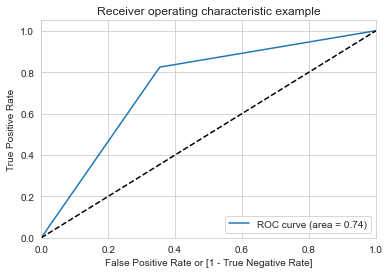

(array([0.        , 0.35406699, 1.        ]),
 array([0.        , 0.82417582, 1.        ]),
 array([2, 1, 0], dtype=int64))

In [337]:
draw_roc(y_pred_final.status, y_pred_final.predicted)

In [339]:
print(classification_report(y_pred_final.status, y_pred_final.predicted))

              precision    recall  f1-score   support

           0       0.89      0.65      0.75       209
           1       0.50      0.82      0.62        91

    accuracy                           0.70       300
   macro avg       0.70      0.74      0.69       300
weighted avg       0.78      0.70      0.71       300



In [268]:
## Finding Optimal Cutoff Point
## Optimal cutoff probability is that prob where we get balanced sensitivity and specificity

In [269]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_pred_final[i]= y_pred_final.Default_Prob.map( lambda x: 1 if x > i else 0)
y_pred_final.head()

,ID,status,Default_Prob,predicted,...,0.6,0.7,0.8,0.9
0,521,1,0.312332,1,...,0,0,0,0
1,737,0,0.382974,1,...,0,0,0,0
2,740,0,0.483831,1,...,0,0,0,0
3,660,0,0.312332,1,...,0,0,0,0
4,411,0,0.080802,0,...,0,0,0,0


In [270]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_pred_final[i]= y_pred_final.Default_Prob.map( lambda x: 1 if x > i else 0)
y_pred_final.head()

,ID,status,Default_Prob,predicted,...,0.6,0.7,0.8,0.9
0,521,1,0.312332,1,...,0,0,0,0
1,737,0,0.382974,1,...,0,0,0,0
2,740,0,0.483831,1,...,0,0,0,0
3,660,0,0.312332,1,...,0,0,0,0
4,411,0,0.080802,0,...,0,0,0,0


In [271]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','recall','precision','f_score'])
from sklearn.metrics import confusion_matrix
num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix( y_pred_final.status, y_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    recall = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    precision = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    f_score = recall*precision/(recall+precision)
    cutoff_df.loc[i] =[ i ,accuracy,recall,precision,f_score]
print(cutoff_df)

     prob  accuracy    recall  precision   f_score
0.0   0.0  0.303333  0.000000   1.000000  0.000000
0.1   0.1  0.450000  0.220096   0.978022  0.179664
0.2   0.2  0.633333  0.516746   0.901099  0.328414
0.3   0.3  0.696667  0.679426   0.736264  0.353352
0.4   0.4  0.720000  0.808612   0.516484  0.315173
0.5   0.5  0.730000  0.909091   0.318681  0.235964
0.6   0.6  0.703333  0.952153   0.131868  0.115827
0.7   0.7  0.706667  0.980861   0.076923  0.071329
0.8   0.8  0.696667  1.000000   0.000000  0.000000
0.9   0.9  0.696667  1.000000   0.000000  0.000000


In [272]:
cutoff_df.to_csv('DevProb.csv')

## ******************************************************
## Valditaion Sample metrices calculation and trying to find optimal cutoff
## ******************************************************

In [273]:
# Creating new column 'predicted' with 1 if Default_Prob> VAL sample KS decile prob else 0
y_pred_final['predicted'] = y_pred_final.Default_Prob.map( lambda x: 1 if x >0.378204 else 0)

# Confusion matrix 
confusion = metrics.confusion_matrix( y_pred_final.status, y_pred_final.predicted )
confusion

array([[151,  58],
       [ 32,  59]], dtype=int64)

In [274]:
#Let's check the overall accuracy.
print('Accuracy:', metrics.accuracy_score( y_pred_final.status, y_pred_final.predicted))
print ('Precision:',metrics.precision_score( y_pred_final.status, y_pred_final.predicted))
print ('Recall:',metrics.recall_score( y_pred_final.status, y_pred_final.predicted))
print ('F1-Score:',metrics.f1_score( y_pred_final.status, y_pred_final.predicted))

Accuracy: 0.7
Precision: 0.5042735042735043
Recall: 0.6483516483516484
F1-Score: 0.5673076923076924


In [275]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [276]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.6483516483516484

In [277]:
# Let us calculate specificity
TN / float(TN+FP)

0.722488038277512

In [278]:
# Calculate false postive rate - predicting default when customer does not have default
print(FP/ float(TN+FP))

0.27751196172248804


In [279]:
# positive predictive value 
print (TP / float(TP+FP))

0.5042735042735043


In [280]:
# Negative predictive value
print (TN / float(TN+ FN))

0.825136612021858


In [281]:
## ROC CURVE

def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(6, 4))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return fpr, tpr, thresholds

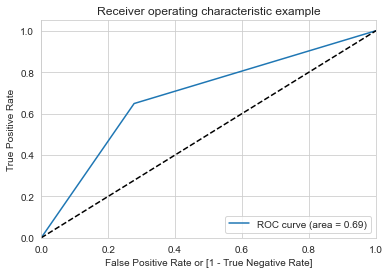

(array([0.        , 0.27751196, 1.        ]),
 array([0.        , 0.64835165, 1.        ]),
 array([2, 1, 0], dtype=int64))

In [282]:
draw_roc(y_pred_final.status, y_pred_final.predicted)

## Finding Optimal Cutoff Point
## Optimal cutoff probability is that prob where we get balanced sensitivity and specificity

In [283]:
# Let's create columns with different probability cutoffs 
numbers = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in numbers:
    y_pred_final[i]= y_pred_final.Default_Prob.map( lambda x: 1 if x > i else 0)
y_pred_final.head()

,ID,status,Default_Prob,predicted,...,0.6,0.7,0.8,0.9
0,521,1,0.312332,0,...,0,0,0,0
1,737,0,0.382974,1,...,0,0,0,0
2,740,0,0.483831,1,...,0,0,0,0
3,660,0,0.312332,0,...,0,0,0,0
4,411,0,0.080802,0,...,0,0,0,0


In [284]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','recall','precision','f_score'])
from sklearn.metrics import confusion_matrix
num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix( y_pred_final.status, y_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    recall = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    precision = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    f_score = recall*precision/(recall+precision)
    cutoff_df.loc[i] =[ i ,accuracy,recall,precision,f_score]
print(cutoff_df)

     prob  accuracy    recall  precision   f_score
0.0   0.0  0.303333  0.000000   1.000000  0.000000
0.1   0.1  0.450000  0.220096   0.978022  0.179664
0.2   0.2  0.633333  0.516746   0.901099  0.328414
0.3   0.3  0.696667  0.679426   0.736264  0.353352
0.4   0.4  0.720000  0.808612   0.516484  0.315173
0.5   0.5  0.730000  0.909091   0.318681  0.235964
0.6   0.6  0.703333  0.952153   0.131868  0.115827
0.7   0.7  0.706667  0.980861   0.076923  0.071329
0.8   0.8  0.696667  1.000000   0.000000  0.000000
0.9   0.9  0.696667  1.000000   0.000000  0.000000


In [285]:
cutoff_df.to_csv("Valprob.csv")

# Non Parametric (XG BOOST)

In [291]:
X=df.drop(['status'], axis=1)
y=df['status']
#Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7,test_size=0.3,random_state=42)

In [292]:
from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm
import matplotlib.pylab as plt
from sklearn.metrics import classification_report

%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4


Accuracy of the GBM on test set: 0.750
              precision    recall  f1-score   support

           0       0.80      0.86      0.83       209
           1       0.61      0.49      0.55        91

    accuracy                           0.75       300
   macro avg       0.70      0.68      0.69       300
weighted avg       0.74      0.75      0.74       300



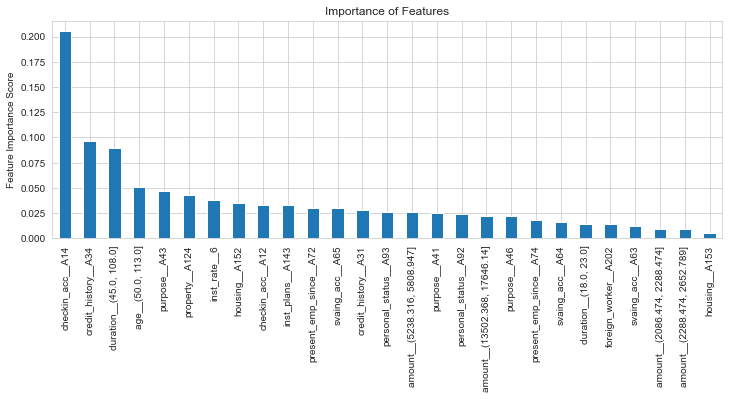

In [295]:
baseline = GradientBoostingClassifier(learning_rate=0.1, n_estimators=200,max_depth=3, min_samples_split=20, min_samples_leaf=10, subsample=1,max_features='sqrt', random_state=10)
baseline.fit(X_train[selected_columns],y_train)
predictors=list(X_train[selected_columns])
feat_imp = pd.Series(baseline.feature_importances_, predictors).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score')
print('Accuracy of the GBM on test set: {:.3f}'.format(baseline.score(X_test[selected_columns], y_test)))
pred=baseline.predict(X_test[selected_columns])
print(classification_report(y_test, pred))

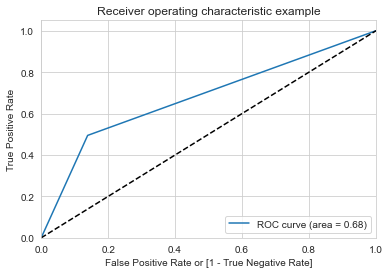

(array([0.        , 0.13875598, 1.        ]),
 array([0.        , 0.49450549, 1.        ]),
 array([2, 1, 0], dtype=int64))

In [296]:
draw_roc(y_test,pred)

#####   End

##### Thanks